# PubChem validation
This notebook demonstrates a new (?) idea in LBVS validation - pinging the pubchem server for assays for a given compound / target pair, and assessing the Outcome field. 

The main difficulty/novelty here is automating the approach while ensuring it gets the CORRECT assay. This is because many targets have different names, and there is no standard format for assay descriptions *or* outcomes.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sys
sys.path.append("..")
import utils
import numpy as np

from sklearn.ensemble import RandomForestClassifier

# Make some structure-predictions with label correlations:



In [2]:
#all labels:
interaction_matrix = sparse.load_npz('../0_data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../0_data/pchembl_chemicals.csv')
targets_df= pd.read_csv('../0_data/subset_targets.csv')

uniprots = pd.read_csv('./uniprot_accessions.csv').drop_duplicates(['chembl_id', 'accession', 'pref_name'])
targets_df = targets_df.merge(uniprots, on=['chembl_id', 'pref_name']).drop(['year', 'canonical_smiles', 'lig_chemblid'],axis=1)



In [3]:
train, test, fps = utils.load_time_split(year=2030, 
                                         return_fingerprints=True) #set a year after now to get ALL records

In [4]:
fps.shape

(358938, 32768)

In [4]:
def fold(arr):
    folded_arr = arr[:,:int(arr.shape[1]/2)] + arr[:,int(arr.shape[1]/2):]
    return folded_arr
fpsize = 2048
while fps.shape[1]>fpsize:
        fps = fold(fps)

In [5]:
%%time
from sklearn.linear_model import LogisticRegression


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 7.87 µs


In [6]:
lr = LogisticRegression()

In [8]:
from sklearn.multioutput import MultiOutputClassifier

In [9]:
moc = MultiOutputClassifier(lr)

In [10]:
moc.fit(fps, train.toarray())

/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

KeyboardInterrupt: 

In [6]:
probability_matrix = rfc.predict_proba(fps)

In [7]:
probability_matrix = np.vstack([i[:,1] for i in probability_matrix]).T

In [8]:
probability_matrix

array([[1.97387527e-03, 6.41566610e-03, 2.47628179e-03, ...,
        2.52276389e-03, 2.52363336e-03, 1.84714062e-02],
       [7.83374661e-04, 1.09134801e-02, 3.95303677e-03, ...,
        1.47904481e-04, 9.33212883e-05, 4.46078431e-05],
       [6.73144054e-04, 1.76469309e-02, 1.08389103e-02, ...,
        1.68243879e-03, 1.54898564e-03, 7.08111027e-04],
       ...,
       [1.27297708e-03, 1.02907578e-02, 7.33615289e-03, ...,
        2.20177047e-03, 5.52794867e-03, 2.00597120e-04],
       [1.92406381e-03, 1.14619752e-02, 1.00654467e-02, ...,
        5.73935322e-04, 2.06202935e-03, 5.80802196e-04],
       [4.01326543e-03, 4.81806842e-03, 2.06757880e-03, ...,
        1.21600531e-04, 4.76304832e-04, 1.10576697e-03]])

In [9]:


#now make all Known predictions very negative (so we don't sample them.)
labels_rows, labels_cols = interaction_matrix.nonzero()
probability_matrix[labels_rows,labels_cols] = -1e6

probability_arr = probability_matrix.copy()



In [10]:
##sort the predictions in order of probability, highest first. 

arr = probability_matrix#.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
0.8582154123642105
Should be a low number >= 0:
-1000000.0
Sorted array indices:


array([[258566,    231],
       [301291,    231],
       [265778,    184],
       ...,
       [188212,    283],
       [342514,    188],
       [265208,    184]])

In [12]:
#sanity check - make sure the ligand IDX, smiles, and target IDX and target names line up:

for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['lig_chemblid'].iloc[pair[0]]
    predicted_target = targets_df['pref_name'].iloc[pair[1]]
    tid = targets_df[targets_df['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)

CCCN(c1ccc... Fibroblast growth factor receptor 1 	 Fibroblast growth factor receptor 1
CHEMBL3890126 CCCN(c1ccc2ncc(nc2c1)c3cnn(C)c3)c4cc(OC)cc(OC)c4
COc1cc(OC)... Fibroblast growth factor receptor 1 	 Fibroblast growth factor receptor 1
CHEMBL3969061 COc1cc(OC)cc(c1)N(CC(C)C)c2ccc3ncc(nc3c2)c4cnn(C)c4
OC(=N)c1cn... Tyrosine-protein kinase JAK2 	 Tyrosine-protein kinase JAK2
CHEMBL3903592 OC(=N)c1cn(nc1Nc2ccc(cc2)C(F)(F)F)[C@@H]3CC[C@@H](C[C@H]3C#N)N(CC4CC4)CC5CC5
Cl.COc1cc(... Fibroblast growth factor receptor 1 	 Fibroblast growth factor receptor 1
CHEMBL3948698 Cl.COc1cc(OCCO)cc(c1)N(CC2CC2)c3ccc4ncc(nc4c3)c5cnn(C)c5
COc1cc(OCC... Fibroblast growth factor receptor 2 	 Fibroblast growth factor receptor 2
CHEMBL3935912 COc1cc(OCCO)cc(c1)N(CCCO)c2ccc3ncc(nc3c2)c4cnn(C)c4
Cl.COc1cc(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL3904814 Cl.COc1cc(OC)cc(c1)N(CCn2cc(C)nc2C)c3ccc4ncc(nc4c3)c5cnn(C)c5
COc1cc(OC)... Fibroblast growth f

# PubChem-pinging 

This became much cleaner when wrapped in a class. The below uses a class to perform a number of functions:

- save/load checkpoints - i.e. if something breaks, or you want to come back to this later after shutting the laptop, you can save all the data and load it afterwards to pick back up
- ping `pubchempy` for compound ID (CID) numbers.
- ping `chembl_webresource_client` for target synonyms
- ping pubchem REST API for assays associated with a CID
- records all of this stuff in dicts to be saved as JSON so I can parse it later. 

In [13]:
class PubChemValidator(object):
    def __init__(self, targets_df, smiles, interaction_matrix, fps):
        self.tdf = targets_df
        self.interaction_matrix = interaction_matrix
        self.fps = fps
        self.smiles = smiles

        self.ligands = {}
        self.targets = {}
        self.predictions = {}

    def load_checkpoint(self, ligands=True, targets=True, predictions=True):
        if ligands:
            self.ligands = json.load(open('ligands_rf.json', 'r'))
        if targets:
            self.targets = json.load(open('targets_rf.json', 'r'))
        if predictions:
            self.predictions = json.load(open('predictions_rf.json', 'r'))

    def save_checkpoint(self, ligands=True, targets=True, predictions=True):
        with open('ligands_sea.json', 'w') as fp:
            json.dump(self.ligands, fp, indent=4,)
        with open('targets_sea.json', 'w') as fp:
            json.dump(self.targets, fp, indent=4,)
        with open('predictions_sea.json', 'w') as fp:
            json.dump(self.predictions, fp, indent=4,)

    def has_ligand(self, idx):
        if str(idx) in self.ligands:
            if 'smi' in self.ligands[str(idx)]:
                return True
        return False


    def has_target(self, idx):
        return str(idx) in self.targets

    def has_prediction(self, l_idx, t_idx):
        return str(l_idx)+':'+str(t_idx) in self.predictions

    def create_prediction(self, l_idx, t_idx, prob):
        record = dict()
        record['prob'] = str(prob)
        nn = self.get_nnrank_of_target(l_idx, t_idx)
        record['nn'] = nn

        self.predictions[str(l_idx)+':'+str(t_idx)] = record

    def create_target(self, idx):
        self.targets[str(idx)] = dict()
        record = self.targets[str(idx)]

        pref_name = self.tdf['pref_name'].iloc[idx]
        tid = self.tdf[self.tdf['pref_name']==pref_name]['chembl_id'].iloc[0]
        accession = self.tdf[self.tdf['pref_name']==pref_name]['accession'].iloc[0]

        record['pref_name'] = pref_name
        record['tid'] = tid
        record['accession'] = accession

    def create_ligand(self, idx):
        self.ligands[str(idx)] = dict()
        record = self.ligands[str(idx)]

        smi = smiles['canonical_smiles'].iloc[idx]
        chemblid = smiles['lig_chemblid'].iloc[idx]
        cid = self.get_cid(smi)
        
        #now get active assays:
        aids = self.get_assays_given_cid(cid, activity='active')
        active_accessions = self.get_uniprot_accession_from_aid(aids)
        
        #now get inactive assays:
        aids = self.get_assays_given_cid(cid, activity='inactive')
        inactive_accessions = self.get_uniprot_accession_from_aid(aids)

        record['smi']=smi
        record['chemblid'] = chemblid
        record['cid'] = cid
        record['actives'] = active_accessions
        record['inactives'] = inactive_accessions
        
################################    
    def get_assays_given_cid(self, cid, activity='active'):
        url  = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'
        url += str(cid)
        url += '/aids/JSON?aids_type='
        url += activity

        out = json.loads(requests.get(url).content)
        assay_ids = self.get_aids_from_pugrest_output(out)
        return assay_ids
    
    def get_uniprot_accession_from_aid(self, assay_ids):
        accession_dict = {}
        while len(assay_ids)>0:
            end = min(400, len(assay_ids))
            aids = assay_ids[:end]
            concat_aids = ','.join(aids)

            url  = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/'
            url += concat_aids
            url +='/targets/ProteinAccession/JSON'
            out = json.loads(requests.get(url).content)

            accessions = self.parse_accessions_from_pugrest_output(out)
            accession_dict = {**accession_dict, **accessions}

            assay_ids = assay_ids[end:]

        return accession_dict
    
    def get_aids_from_pugrest_output(self, output):
        assay_ids = []
        if 'InformationList' in output.keys():
            assay_ids += [str(i) for i in output['InformationList']['Information'][0]['AID']]
        return assay_ids

    def parse_accessions_from_pugrest_output(self, output):
        accessions = {}
        if 'InformationList' in output.keys():
            for aid in output['InformationList']['Information']:
                if 'ProteinAccession' in aid:
                    available_accessions = aid['ProteinAccession']
                    for accession in available_accessions:
                        if '_' not in accession:
                            accessions[aid['AID']] = accession
        return accessions


################################
    def get_cid(self, smi):
        try:
            c = pcp.get_compounds(smi, 'smiles')[0]
            return c.cid
        except Exception as e:
            print(e)
            return 'cid_failed'
    
    def get_nnrank_of_target(self, ligand_idx, target_idx):
        positives = self.interaction_matrix[ligand_idx].nonzero()[1]
        all_distances = self.fast_jaccard(self.fps[ligand_idx], self.fps)[0]
        s = np.argsort(all_distances)

        pred = target_idx
        curr_rank = 0
        count=1
        preds = []
        seen = []

        while pred not in seen:
            predictions = self.interaction_matrix[s[count]].nonzero()[1]
            preds = np.setdiff1d(predictions,positives)
            preds = np.setdiff1d(preds, seen)
            curr_rank = len(seen)
            seen += list(preds)
            if len(preds)>0:
                 curr_rank+= np.mean(np.arange(len(preds))+1)
            count+=1

        return curr_rank
    
    ##The following is to calculate AVE bias:
    def fast_jaccard(self, X, Y=None):
        """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
        if isinstance(X, np.ndarray):
            X = sparse.csr_matrix(X)
        if Y is None:
            Y = X
        else:
            if isinstance(Y, np.ndarray):
                Y = sparse.csr_matrix(Y)
        assert X.shape[1] == Y.shape[1]

        X = X.astype(bool).astype(int)
        Y = Y.astype(bool).astype(int)
        intersect = X.dot(Y.T)
        x_sum = X.sum(axis=1).A1
        y_sum = Y.sum(axis=1).A1
        xx, yy = np.meshgrid(x_sum, y_sum)
        union = ((xx + yy).T - intersect)
        return (1 - intersect / union).A

In [14]:

pcv = PubChemValidator(targets_df, smiles, interaction_matrix, fps)
#pcv.load_checkpoint()

# How many predictions to sample, and which ones?

Ideally we want to sample a good few predictions that have high probabilities. But we also want to see how well it performs at lower probabilities. The problem is that even sampling over the highest, say, 10,000,000 predictions will be highly biased toward lower probabilities! So we try to weight the random selection to balance it out, selection an even number of high- and low-scoring predictions.

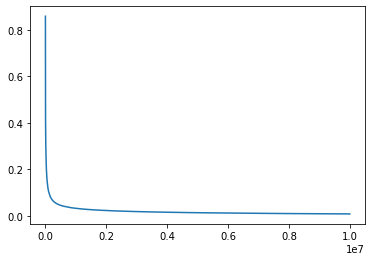

In [15]:
num = 10_000_000
probs = probability_arr[arr_sorted[:,0][:num], arr_sorted[:,1][:num]]
plt.plot(probs)

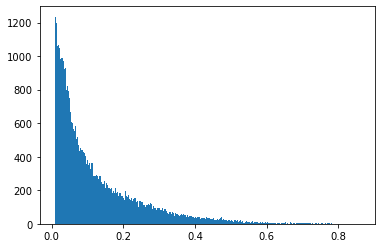

In [16]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(10*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

# Do the sampling.


In [18]:
import tqdm
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample]), 
                                            total=len(sample),
                                           smoothing=0):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
       
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        #if the ligand has any active or inactive assays, we will save them:
        actives = pcv.ligands[str(ligand_idx)]['actives']
        inactives = pcv.ligands[str(ligand_idx)]['inactives']
        if (len(actives) + len(inactives)) > 0:
            #then record the prediction:
            if not pcv.has_prediction(ligand_idx, target_idx):
                pcv.create_prediction(ligand_idx, target_idx, probability)

    except KeyboardInterrupt:
        raise
    except Exception:
        pass
                
    if count>0 and count%1000==0:
        pcv.save_checkpoint()



/home/lewis/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


[271302     88]
[66271     8]
[148191    168]
[296307    324]
[295021    167]
[75013   129]
[272318    184]
[257473    117]
[102555    211]
[99528    91]
[38660     5]
[142309    184]
[241856    144]
[317246     74]
[241425    238]
[131479    151]
[245412     74]
[92402   103]
[19673   167]
[274107    174]
[99476   123]
[231760     96]
[94148    12]
[30754   200]
[59282   105]
[310676    200]
[324329    154]
[75152   209]
[55221   233]
[326653     53]
[131742    247]
[104455    213]
[307743    140]
[312412     74]
[168812    205]
[169355    210]
[142510    148]
[117713    103]
[249167    161]
[312454    247]
[147424     74]
[110169    134]
[252883    167]
[53506   216]
[14897   205]
[108564    235]
[332360    229]
[33117    53]
[329830    226]
[44853   226]
[145006    199]
[51566   180]
[210638    173]
[337575    213]
[264700    111]
[15941   174]
[89551    96]
[315496     90]
[57875   226]
[189123    226]
[134984     77]
[47682   214]
[38700   154]
[337046    256]
[63524   229]
[35705

[313808    311]
[115814    119]
[355262      1]
[198931    153]
[106773    124]
[180608    216]
[334736    226]
[194030    172]
[204176    275]
[292702    306]
[107311    157]
[332655    110]
[314896    233]
[141760    216]
[192090    101]
[190065     18]
[9779  228]
[319644    226]
[291464    206]
[100268     91]
[336264    312]
[315711     56]
[135711    283]
[129357     91]
[281127    223]
[23857   229]
[320831    228]
[30599    53]
[206532    161]
[10623   261]
[333477    172]
[251793     91]
[318823      6]
[253642    167]
[48365   213]
[119421    101]
[105085     77]
[350173    119]
[3879  201]
[168254    211]
[139035     29]
[149157    226]
[285268    136]
[169169    159]
[21193   229]
[35396   226]
[181817     22]
[299276    226]
[32454    71]
[140627    211]
[67715   215]
[113905    217]
[194533     77]
[350075    174]
[27625   111]
[6868  220]
[9292  157]
[353593    213]
[318331    144]
[20607   140]
[248990    205]
[57626   229]
[97000    23]
[325403    108]
[307023    261]


[312114     77]
[132141    281]
[29500    53]
[205835    257]
[159180    140]
[337535     81]
[173537    226]
[192398    220]
[13673    96]
[141078    184]
[158283    136]
[1014  117]
[103466    290]
[105251    316]
[126604    213]
[75469   167]
[263023    167]
[138359    168]
[260598     77]
[87599   210]
[214998    321]
[104518    136]
[98243   167]
[115225    101]
[344156    119]
[254015      9]
[294107    134]
[6738  206]
[116067    210]
[84134   277]
[56201   226]
[186278    101]
[355279    284]
[319093    154]
[350594     36]
[312427    124]
[27511   199]
[25232   226]
[91773    87]
[109658    190]
[350625    277]
[77995   284]
[284928    226]
[32422   226]
[197673    213]
[329395    226]
[19564   226]
[74323   185]
[108242    168]
[293251    182]
[104382    229]
[162438    194]
[270958    154]
[304729     22]
[304860    213]
[354395    210]
[311360    154]
[325373    184]
[306518    226]
[323672    140]
[305718    291]
[253759    123]
[157052     77]
[294832    178]
[350647    1

[207208    175]
[98833   211]
[20683    87]
[132137    215]
[209567     42]
[98829   211]
[171716    147]
[251545    258]
[198397     81]
[15632    55]
[55694   226]
[50732   328]
[36961   153]
[178974    129]
[37578   213]
[135205    122]
[74715   129]
[65134   215]
[282585    291]
[106007    239]
[183399     96]
[247381    168]
[313796     91]
[164324    205]
[215907    154]
[71178   226]
[298288     22]
[161600    226]
[293590    258]
[94792   210]
[161243    228]
[249143     85]
[150018    201]
[108605     52]
[4707  205]
[136162    110]
[80481   157]
[183398     96]
[340707    122]
[262783     94]
[344510    143]
[260628    159]
[45470   161]
[128618    184]
[131846    303]
[123937    167]
[2918  119]
[74692    74]
[321991     52]
[35053   276]
[279417    110]
[20907   229]
[107950     71]
[178405    154]
[469  87]
[176068    210]
[104491    200]
[249955    198]
[269010    213]
[258105    205]
[249104    277]
[114023    105]
[293056     52]
[94910    29]
[105 226]
[31136   190]
[1

[99769    71]
[318089    148]
[226360    144]
[349047    283]
[358910     91]
[196101    105]
[185465    226]
[186261    124]
[200991    228]
[310898    181]
[223744     95]
[120728    319]
[32054   226]
[72851    53]
[47414    53]
[191003    216]
[250347    119]
[184514    119]
[343422     91]
[122948    129]
[92421    85]
[134887    204]
[313307    211]
[256684    121]
[114376    300]
[33980   229]
[170994    226]
[6366  105]
[181103    143]
[126896     88]
[186515    213]
[41190    84]
[171752    226]
[355914     59]
[189066    153]
[180848    308]
[145025    199]
[211096    138]
[209380    138]
[150903    180]
[348743     79]
[253264     71]
[50231   164]
[175455     77]
[352957    211]
[182513    226]
[327592    115]
[334330     52]
[344615     71]
[36612   226]
[352451     91]
[150267    229]
[195791    167]
[190985    226]
[158550    211]
[201345     85]
[199729    159]
[12921   217]
[170415     40]
[202057     77]
[297478     57]
[80029   105]
[73195    16]
[153333     27]
[114

[9517  144]
[318477    144]
[118063    136]
[129069    309]
[57133    53]
[62757    53]
[316371    283]
[40733   226]
[252418    129]
[344548     91]
[303158     73]
[191967    210]
[1418  154]
[344225    228]
[28885   157]
[200933     95]
[350663    121]
[28884   226]
[181107    144]
[208281    184]
[151307    311]
[327609    217]
[29988   274]
[225242    130]
[344559     26]
[327846     82]
[156511    256]
[172599     12]
[251053    147]
[174914     68]
[169282    172]
[338861     91]
[35397   123]
[209712    226]
[110435    228]
[357295     91]
[73713   110]
[183134     77]
[160217     91]
[209640     52]
[101850    180]
[157519    157]
[5840  153]
[30599   216]
[70530   268]
[343001    129]
[108431    117]
[35659   152]
[134204     88]
[15511    71]
[290727    332]
[26638   216]
[114160    201]
[344396    167]
[258711    144]
[256459    228]
[327953    123]
[150988    228]
[199844    277]
[120000    226]
[216018    205]
[356378    170]
[211584    324]
[73299   153]
[309288    226]


[10505   226]
[295914    173]
[55315   133]
[30806   213]
[145395     31]
[168421    190]
[30664    71]
[80886   228]
[271110    129]
[354202    119]
[57359   268]
[352243    213]
[142493    229]
[322653    119]
[123974    105]
[58907   228]
[315545      1]
[208985    226]
[17004   215]
[13813   119]
[89678    80]
[63854   180]
[113773    303]
[70653   226]
[85361    82]
[115664    108]
[247148    136]
[18062   124]
[183599    190]
[129409    201]
[64836   268]
[27771   110]
[188545    153]
[62969   226]
[184648    110]
[53351   153]
[51530   214]
[77731   134]
[157243    148]
[175507     22]
[248043     71]
[123428    218]
[169380    168]
[358398    168]
[39594   121]
[76414   214]
[239772    306]
[172924    216]
[311924     52]
[132060    131]
[120495     88]
[280921    319]
[181339    213]
[228417    292]
[270276     71]
[71790   226]
[67213    81]
[351244     68]
[96239   201]
[319249    182]
[51061   226]
[24622   316]
[201102    180]
[141256    229]
[82790   122]
[95769   157]
[1

[55087   304]
[91253    91]
[303159     79]
[88901    22]
[311761     74]
[172199    153]
[46128   105]
[300689    226]
[105529    120]
[3800  235]
[34540   268]
[339580     81]
[89806   129]
[131126     71]
[12504   129]
[39894   195]
[175270    154]
[106399     56]
[93481   211]
[94080   213]
[126103    316]
[352440     71]
[41618   136]
[173037      1]
[162043    210]
[52569   213]
[212087    283]
[235531     88]
[88266   316]
[71519   215]
[206556    161]
[181730     29]
[37185   216]
[18701   226]
[329809     96]
[338369    217]
[130469     84]
[26617   211]
[73474   234]
[251007    119]
[107192    167]
[175182    178]
[182867     22]
[78590   167]
[337726    200]
[67324    53]
[242630     74]
[327264    204]
[313324    288]
[138592    309]
[242430    140]
[32009   283]
[223749     95]
[195186    226]
[247497    144]
[48334     8]
[125433    274]
[321731    226]
[21570   226]
[24081   216]
[138665    117]
[279422    214]
[157331    294]
[37132   258]
[33856    91]
[173503    226]


[135083     77]
[354465     96]
[250663    217]
[135171    228]
[330686    283]
[182607    226]
[116183    162]
[130115    155]
[155939     65]
[171643    154]
[72463   157]
[185309    311]
[292046     85]
[305792     79]
[205037    277]
[43956   261]
[37935     2]
[264404     52]
[118808    155]
[179222    129]
[118097    105]
[250648    105]
[129589     97]
[6817  175]
[210924    161]
[354145    115]
[241477     42]
[267170    312]
[92113   152]
[355088     85]
[241876    147]
[178814    116]
[141729    218]
[255607     94]
[331623    201]
[135024    167]
[20128   226]
[185101    130]
[354197    292]
[325839    190]
[101366    167]
[202691     71]
[237220    122]
[131613    226]
[160125    154]
[30651   216]
[49442   154]
[178873    101]
[103525     82]
[226603     77]
[64876    91]
[2931  119]
[351754    180]
[285539    174]
[89573   121]
[273132     79]
[212025    300]
[277087     64]
[356586    294]
[56493   226]
[31171   226]
[59092   226]
[335582    216]
[150243    200]
[312114 

[158889     56]
[273576     23]
[197775    124]
[158959    201]
[175374    119]
[152171     62]
[243771     94]
[108256    316]
[238830    226]
[333495     71]
[63571   226]
[36551   226]
[271850     80]
[89409   226]
[337170     82]
[318108    172]
[336808    168]
[351815     96]
[48403   123]
[46231   112]
[227784    258]
[320904    103]
[54269    91]
[183059    300]
[40373   123]
[242409    258]
[13851   100]
[150841    274]
[208524    319]
[60398   124]
[298457    299]
[29557   226]
[310795     71]
[261740     71]
[317209     53]
[187661     85]
[37343   283]
[11548   310]
[183918    226]
[151046    101]
[350675    105]
[64996   213]
[282955    291]
[285551    321]
[114411     52]
[163786    316]
[93061    91]
[83606    91]
[174806    151]
[42073   226]
[71784   167]
[181607    190]
[156614    167]
[103143    275]
[77733   116]
[136302    210]
[256450     36]
[12101    56]
[167279    216]
[135894    157]
[27996    82]
[158768    105]
[344632    105]
[71898   218]
[344763    143]
[1

[60314   105]
[125140    258]
[107296    119]
[332614    228]
[327937     77]
[196038    157]
[50518   226]
[334209    322]
[23177   153]
[341095    210]
[112693     91]
[73426   168]
[275946     22]
[126805    184]
[139855     75]
[350112    119]
[134051    173]
[89174    88]
[193750    164]
[325958    125]
[346708    226]
[276470    201]
[348660     47]
[97736   123]
[103642    226]
[105989     71]
[352956    226]
[207033    136]
[347181    324]
[124509    159]
[3026   71]
[337918    167]
[330304    216]
[114847    323]
[7592  153]
[10105    77]
[268297    306]
[82324    71]
[181341    167]
[326224     85]
[311660     91]
[308285     71]
[36636    81]
[311447    157]
[190367    105]
[55181   122]
[352489    221]
[137321     85]
[183803    306]
[314848    312]
[64710   177]
[161084    101]
[104615    107]
[14114   122]
[335750    154]
[44162   215]
[253593    167]
[319914    167]
[224328    239]
[28318   123]
[295724     87]
[337148    193]
[248076    316]
[31151   226]
[7443  167]
[1

[100810    226]
[176251    228]
[336566    201]
[138067     74]
[329811    136]
[50899   218]
[37446   105]
[155822    200]
[193806    246]
[30045   216]
[111832    143]
[175942    117]
[196540    129]
[161813     82]
[68359   201]
[49489    81]
[186518     91]
[108625     29]
[59691    73]
[81401   129]
[311765    229]
[58104   213]
[135072    110]
[256318    294]
[170455    123]
[162079    177]
[35685   153]
[37725   226]
[304 105]
[89985   276]
[236872    258]
[15650   146]
[303004     55]
[201435     73]
[265176    138]
[168678    210]
[276855     71]
[357365    307]
[171003    226]
[22031   226]
[310649    141]
[171503    226]
[59769   277]
[38113   211]
[31750   226]
[331181    200]
[146210     60]
[242479     71]
[129060    325]
[318533    154]
[248247    105]
[53767   229]
[37344   201]
[279619    112]
[249297     91]
[191896    201]
[341966    228]
[177052    201]
[183189     77]
[318394     53]
[162997    226]
[116714    226]
[54785   119]
[318975     14]
[62023   123]
[19560

[175229    168]
[18404    91]
[21130   132]
[46674     8]
[262713    143]
[140140    136]
[42070   259]
[327929    228]
[23883   213]
[159306    122]
[180425    307]
[351609     77]
[337852    205]
[64585   124]
[280406    306]
[16328   184]
[117305    311]
[348979    226]
[60089    53]
[153640     91]
[333522    110]
[173977     85]
[55723   167]
[95718   175]
[331338    211]
[261301    258]
[57025     8]
[148846    185]
[131401     21]
[79956    95]
[160635     77]
[192300    283]
[48456   226]
[57225   215]
[297620    321]
[22414   153]
[169515    154]
[299458    223]
[193962     46]
[304328     52]
[300748    197]
[110319    105]
[257997    119]
[53867   210]
[312845     91]
[170053    123]
[306349    161]
[326141    226]
[46841   134]
[15073   172]
[99704     1]
[263901    199]
[137239    174]
[338256    168]
[261837    206]
[313967    151]
[331159    226]
[35880   201]
[231694     74]
[168631    228]
[170965    226]
[251476    151]
[167324    197]
[178572    140]
[65861   213]
[2

[161451    312]
[197970     43]
[3106  101]
[104866     53]
[246716    202]
[212494    206]
[231734    268]
[156954    210]
[141554    216]
[262000    213]
[87906   119]
[19745   227]
[307082     71]
[276632    184]
[164179    235]
[13050   309]
[52007   157]
[1605  159]
[78160    91]
[101105     85]
[318210    157]
[168710    201]
[129384    226]
[157583    211]
[146147    230]
[202583    161]
[329119    154]
[352790     91]
[183429     81]
[15529   146]
[154403    210]
[155735    129]
[86720   119]
[61467   226]
[315681    210]
[327190    226]
[346218     97]
[52503   213]
[328661    124]
[130730    119]
[176439     87]
[69735   216]
[267481    173]
[105737     42]
[132152    316]
[135810     97]
[340095    285]
[223858     95]
[38325   214]
[90233   258]
[71337   224]
[292574    184]
[18196   138]
[188281    229]
[340951    164]
[100570     88]
[357104    119]
[42047   226]
[239566     52]
[114442    206]
[21376    77]
[33856    85]
[199897    140]
[344647    215]
[195552    213]
[9

[163895    200]
[67725    53]
[168061    152]
[169414    211]
[137845    259]
[303328    228]
[325658    277]
[175689     43]
[354761    294]
[99622   151]
[68633    91]
[137181    136]
[354764     74]
[170764    201]
[102399    157]
[154816    154]
[159079    206]
[166377     53]
[38033   205]
[50676   213]
[183391     91]
[105915    226]
[249837     43]
[79559   168]
[328301    143]
[204640    226]
[189879    154]
[252903    143]
[230323     55]
[166405    229]
[230542    290]
[274278    107]
[160849    226]
[103611    303]
[106748    174]
[201581    213]
[322813     85]
[268374     71]
[342549    131]
[144088    213]
[25704   121]
[73260   235]
[19406    53]
[258066    281]
[51917   226]
[353074    119]
[313388    112]
[16403    31]
[54118   268]
[155262    129]
[61726   215]
[318577     85]
[171390    216]
[108733    184]
[330094     48]
[30678    96]
[226559    258]
[170810    123]
[84308    74]
[134163     52]
[104891    140]
[17985   110]
[98821   211]
[150894    180]
[177504   

[274799     77]
[39863   129]
[24741   153]
[113613    184]
[194217    228]
[67122   205]
[63856   174]
[280165    201]
[86267   228]
[143521    167]
[351257    119]
[48202   199]
[88860   216]
[205587    276]
[159142     77]
[65735    81]
[187351    184]
[104895    226]
[159575     91]
[222080    138]
[25607   201]
[47051    91]
[82935   151]
[286338    213]
[311135    182]
[62894   226]
[10224   117]
[219435    216]
[257388    213]
[189358    119]
[190889    228]
[305353    101]
[112452     74]
[354049    119]
[84156    91]
[70026   213]
[337631    147]
[53536   277]
[155817     91]
[17974    85]
[129929    153]
[191439    101]
[171523    226]
[160111    205]
[74199   140]
[97625   303]
[316490    226]
[352425    153]
[265159    201]
[169475    152]
[176758    214]
[129232     82]
[214689    161]
[162411    129]
[42149   152]
[192318    129]
[278808    223]
[142314     87]
[115150    105]
[339295    178]
[149584    117]
[143578    144]
[197654    236]
[195178    167]
[24308   323]
[2

[267030    199]
[295132    140]
[159893    205]
[186964    115]
[36695   323]
[84415   136]
[113209    112]
[351946    216]
[7215  136]
[126541    259]
[349706     94]
[319031     82]
[178784    167]
[195569    210]
[195331    122]
[69672   225]
[199566      8]
[117737    316]
[355862    274]
[177550    119]
[169038    226]
[308566    322]
[78128   312]
[157230     74]
[47987    84]
[137005    138]
[139316    123]
[35084   259]
[60564   261]
[27972   226]
[335750    115]
[29613   119]
[316539    215]
[49077   215]
[155469     77]
[194499    117]
[49865    96]
[289977     88]
[64398    91]
[257666     71]
[286002     67]
[298704    261]
[148786    210]
[53110   140]
[44091   228]
[147784    178]
[16494   117]
[4674  154]
[199861    226]
[145348     22]
[106286    265]
[195912     77]
[326783    299]
[227563    105]
[208189    327]
[163545    119]
[190366    136]
[173760    211]
[307070    173]
[314894    209]
[91359    70]
[109575    178]
[6042  281]
[261174    299]
[199594    125]
[106

[229775    122]
[219291    105]
[339556     97]
[58100    44]
[337970    101]
[93639   153]
[326829     91]
[198375    175]
[355977    228]
[65311   216]
[108769    215]
[136536    117]
[173611    129]
[237618     55]
[179665    201]
[86227   117]
[104968    204]
[14939   115]
[73483   180]
[320240    316]
[62210   129]
[163367     52]
[96827   215]
[189169    316]
[330499    175]
[327049    216]
[12220   299]
[318288     71]
[62320   123]
[14717   169]
[353804    154]
[105228    167]
[15944   124]
[208869     88]
[336858    138]
[337680    313]
[125464    159]
[17295    85]
[4765  122]
[139689    263]
[242423     22]
[112838    213]
[147430    123]
[6655   14]
[136145     40]
[34346   229]
[72364    96]
[94697   201]
[151040     91]
[165724    211]
[153360     84]
[135422    214]
[222166    292]
[247542    154]
[43988   261]
[337774    167]
[26000    53]
[74001    85]
[306894    258]
[49623   226]
[59730   129]
[154969    172]
[122478    210]
[72205   216]
[194834    235]
[264453     

[15573   198]
[94618    91]
[351593    103]
[342399    216]
[26535   268]
[2457  103]
[248043     29]
[141833    161]
[309896     71]
[35555   213]
[31881   153]
[116314    201]
[105571    246]
[91055   233]
[258656     71]
[24041   268]
[25933   321]
[336749     22]
[86435   105]
[247260    226]
[34455    48]
[102927    226]
[153792    131]
[28008   213]
[41473   226]
[224347     77]
[32251   125]
[11869    81]
[153509    167]
[248379    134]
[124853     91]
[177305     94]
[23519   226]
[67645   226]
[311039     22]
[53196    56]
[102413    180]
[327364    101]
[155311     77]
[324796    213]
[240026    195]
[69621    17]
[315619    249]
[93153   129]
[92609   233]
[278344    206]
[102683    226]
[108617    183]
[50029   229]
[72767    53]
[166187    216]
[79415   308]
[22600   215]
[132049    245]
[26182   178]
[117695    144]
[175493    119]
[105865    310]
[41697   229]
[191593    213]
[74450   259]
[177300    226]
[ 97 121]
[269333    138]
[179488     77]
[194121    168]
[55855  

[212574    233]
[229980    186]
[129143    111]
[14762    91]
[286833     71]
[340017    129]
[313606     84]
[5073  283]
[66876   258]
[94513   124]
[339051    216]
[12494    18]
[30990   281]
[241859    144]
[256654    167]
[196402    215]
[143135    321]
[313815     96]
[324713     91]
[260031    152]
[57782   144]
[29715   226]
[92907   226]
[293702    175]
[24607    17]
[127637    281]
[118270    164]
[199463    151]
[173057    201]
[121078    129]
[118026    105]
[130465    167]
[31300   123]
[323626    157]
[120227    310]
[99915   168]
[66561    97]
[345483    215]
[124123     96]
[287706    122]
[59283   226]
[34576   213]
[94340   226]
[195851    151]
[344205    105]
[102464    172]
[357692    316]
[175259    134]
[208684    165]
[176370    323]
[340028     25]
[168863    311]
[68775   261]
[286405    316]
[212483    198]
[154805    205]
[214861     22]
[114562    226]
[96437    38]
[4674   77]
[320646    147]
[8488  154]
[240565    228]
[150373    233]
[29038   226]
[15770  

[166807    101]
[9187  155]
[181737    211]
[115072    155]
[179312    101]
[157194    136]
[226387    180]
[75950   136]
[86906   226]
[232156     57]
[79954   101]
[154868     33]
[23659   229]
[357822     74]
[42865   101]
[39034   309]
[318244    200]
[108528    146]
[145745     84]
[4106   43]
[188459    152]
[192592    175]
[128884     25]
[212729     52]
[342924    123]
[57031   153]
[184982    303]
[253491     71]
[274380    151]
[172859    123]
[204936    129]
[336906    143]
[305103    231]
[298897    107]
[93660    71]
[137213    184]
[24401   306]
[247738     77]
[114502    137]
[167117    268]
[8221  147]
[276578    101]
[54144   105]
[103757    144]
[191074    119]
[197920    172]
[349803     91]
[30475   213]
[140939     22]
[178709     71]
[171642    226]
[133359     98]
[37675   143]
[188533    183]
[230241    311]
[341825    206]
[81293    91]
[295938     77]
[17398   124]
[94430   303]
[180390     99]
[353284     91]
[185961    129]
[60631   180]
[352542    228]
[105

[72347   112]
[288818     91]
[5486  228]
[197215    327]
[356484    215]
[59507   136]
[190902    228]
[170824     73]
[78062   121]
[21162   214]
[266608     71]
[167444    139]
[295733     71]
[100717    117]
[30226   310]
[310222    321]
[153375    226]
[28096   167]
[128558    101]
[79337   182]
[196528    210]
[322059    201]
[254800    167]
[269461    309]
[19483   216]
[47313   226]
[11023    85]
[32529   274]
[230083    127]
[236518    152]
[128770    211]
[61231   216]
[155592     77]
[153371    117]
[118840     24]
[353542     74]
[127735     29]
[70751   283]
[259972    122]
[168821    210]
[187805     74]
[169754    228]
[356089     81]
[165917    162]
[245031     77]
[124626     71]
[127128    101]
[344805    119]
[325642    210]
[12501    74]
[158760    122]
[90236    65]
[311618    277]
[339471    125]
[355582     94]
[242661    290]
[146953     29]
[282062    226]
[358196     85]
[15002    55]
[9318   74]
[66519   123]
[202529    101]
[336729    228]
[125141    100]
[2

[343753    214]
[349731      1]
[106398    162]
[69953   229]
[255519    226]
[66636   226]
[331825    277]
[173801    214]
[62912   261]
[82426   258]
[153785     70]
[56812   123]
[287945     79]
[296452    322]
[99420   269]
[738 121]
[191953     81]
[148912    119]
[83548   167]
[209822    288]
[309596    312]
[55115    96]
[105312    154]
[324868     96]
[205554    312]
[206179    195]
[315667    210]
[202025     31]
[302709     71]
[141115     96]
[270554    306]
[151181    177]
[42438   216]
[166166    226]
[208624    226]
[143715     74]
[138718    154]
[130021    213]
[242550    295]
[212769    178]
[318556    157]
[80529   211]
[276848    184]
[314374     77]
[116619    201]
[74861   303]
[161881     60]
[978 129]
[354785    226]
[94260   226]
[280012     79]
[324479    105]
[342869     85]
[205589    276]
[322079    159]
[109508    261]
[179680    157]
[45247   153]
[289141    284]
[313924     77]
[158759    154]
[336509    173]
[67038    97]
[38771   216]
[190887    205]
[2

[50590   214]
[268962     88]
[330884    281]
[34711   155]
[304981    254]
[328914     85]
[318016    211]
[150252    261]
[41914   153]
[332938    316]
[200472    236]
[24743   154]
[314027    119]
[159102     91]
[161243     77]
[285726    311]
[192433     91]
[334314    185]
[182742     91]
[335373    184]
[73918   174]
[261755    266]
[68986   117]
[269226    121]
[176931     84]
[34966   215]
[199964     85]
[323186    136]
[196923    101]
[182461    134]
[72563    77]
[287048     88]
[230139    173]
[18465    74]
[158921    210]
[119066    303]
[21886   229]
[187499    108]
[27491   226]
[164308    205]
[87308    84]
[283175    144]
[124484     71]
[159689    151]
[48038    77]
[345035     13]
[250927    124]
[303401    173]
[22185   226]
[309987    184]
[18278   110]
[327582    226]
[11022   101]
[181608    155]
[337109    174]
[79426   228]
[330168    168]
[51262   229]
[194882     91]
[3980  324]
[152216    134]
[116994    101]
[259879    223]
[328609    155]
[253444    143]


[298879    167]
[143603    214]
[93414    74]
[22779   213]
[94115    43]
[11650    90]
[118525    226]
[353394     91]
[114900     87]
[196349     61]
[145942     71]
[61356    77]
[16648   258]
[119997    105]
[190347    105]
[27677    56]
[54597     8]
[344875    143]
[52874   128]
[351346    101]
[56884   302]
[118493    117]
[8913   84]
[137983     94]
[108950    122]
[161872    215]
[63036    43]
[104558    208]
[18537   213]
[312854     83]
[99269   162]
[76232   216]
[331099    136]
[183267    119]
[12505   129]
[17863   210]
[132965    174]
[139145    105]
[81915   259]
[207132    206]
[4509  154]
[32126   152]
[258209    101]
[108259    117]
[232945    129]
[37606   122]
[195294    157]
[150248    226]
[70186   229]
[109443    167]
[196166    283]
[74833   151]
[108759    130]
[45851    77]
[188752    167]
[17521   105]
[32944   213]
[196719    167]
[7281  214]
[314804    316]
[12865   162]
[314562    178]
[97989   226]
[69943     5]
[94572   216]
[142714    226]
[264541    2

[334829    123]
[30409    91]
[69709   136]
[292241     71]
[149628    201]
[165863    123]
[351094    226]
[81169   226]
[319001     71]
[165696    201]
[181486    116]
[317926     44]
[38021   180]
[91475   226]
[179864    211]
[230107    226]
[84217   214]
[54733   226]
[176265    161]
[143347    214]
[102781     29]
[94070   151]
[328573    268]
[247117    318]
[159913     71]
[332422    168]
[143541    229]
[181544    290]
[118589    283]
[114456    197]
[107458    226]
[337099     74]
[235716    210]
[342936    105]
[39504   109]
[66782    53]
[197771    101]
[25294   136]
[353958    178]
[337415    258]
[189084     91]
[70000   210]
[191577    215]
[240337    258]
[276198     88]
[348143     28]
[281483     91]
[266867    290]
[26277   226]
[115304    160]
[79059    85]
[194566    122]
[352129     71]
[48230   205]
[102860     45]
[338904    216]
[5512  195]
[252692     25]
[190400    224]
[197281    129]
[299977    103]
[140835    136]
[256318    172]
[269667     78]
[200712   

[195450    228]
[335762    228]
[8369  125]
[61791   258]
[227335    290]
[95026   157]
[37566   268]
[44863   144]
[139035    206]
[314856    228]
[159090    168]
[41170   228]
[339902    216]
[100113    143]
[211629    167]
[20672   213]
[184892    136]
[3515  229]
[254304    122]
[336494    216]
[184701    167]
[303268    174]
[17389   103]
[350755     68]
[146771    226]
[355333     81]
[172096     53]
[320829     29]
[190887     77]
[23840   226]
[315031    129]
[60718   309]
[113921     22]
[7482  229]
[202399    167]
[327400    140]
[136560     68]
[22269    97]
[353977    117]
[189535     91]
[43633   258]
[172345     94]
[185266    216]
[126657    221]
[207408    324]
[259589     71]
[316913     53]
[190873      8]
[199727    183]
[288618    210]
[21715   226]
[286414    117]
[336699    195]
[160423    210]
[340120    311]
[194369    216]
[354921     91]
[234213    167]
[38185   180]
[100521    178]
[322481    216]
[46778   303]
[179969    200]
[7325  229]
[66571   154]
[23490

[955 167]
[198122     97]
[149813     84]
[294038    233]
[352246     97]
[155174    306]
[338729     81]
[226942     91]
[28622   226]
[72410   168]
[41246   213]
[334732    316]
[162875     77]
[325465    256]
[36506   228]
[35230   226]
[175947    228]
[63962   140]
[356566    210]
[98521   103]
[145063    257]
[125566     74]
[11021   119]
[251594    291]
[6497    0]
[287602     25]
[52634   229]
[113705    303]
[16761    68]
[80603   226]
[197734    228]
[2113  204]
[238496     85]
[99918   226]
[283781     79]
[132037    184]
[351195     91]
[61192   281]
[18996   110]
[52702    91]
[283822    258]
[262337    226]
[32084   216]
[324479    143]
[43399   214]
[321329     82]
[187553     48]
[308607    184]
[57974   309]
[4896  124]
[136100    205]
[164028    178]
[198592     43]
[333639    226]
[324527    177]
[213852     88]
[243792    208]
[25472    80]
[159818     91]
[189357    119]
[334025     91]
[328688     71]
[31801   226]
[122330     96]
[286665    136]
[25887   151]
[400

[189907    119]
[35303    77]
[26842   157]
[4371   85]
[58840   117]
[74908    97]
[195374    167]
[102712    226]
[203024    316]
[224313    184]
[135916    112]
[230267     96]
[58544   258]
[318747    201]
[303611    311]
[331048    217]
[187711    136]
[135104    284]
[17913   283]
[174568    180]
[319040    226]
[355672     74]
[350747    117]
[332740    159]
[11444   201]
[294431    121]
[70861   215]
[245017    198]
[185533    308]
[193416    136]
[102003     99]
[304054     81]
[10787   277]
[1045  308]
[248929    303]
[338625    115]
[45656    77]
[21522   226]
[316333    168]
[36506   154]
[293055    214]
[263806    213]
[185175    211]
[200430     22]
[252980    146]
[354202     85]
[106506     91]
[59463   213]
[66384   261]
[243829    119]
[188535     53]
[332285    168]
[30777   144]
[190351    136]
[265109    226]
[104669    213]
[270247     22]
[20226   226]
[313940    228]
[54379   180]
[310243    168]
[71225   229]
[238713    122]
[327282    144]
[54910    53]
[35575

[153814    136]
[6912   47]
[2515  277]
[24764     8]
[336895    153]
[183152     77]
[135578    217]
[222578     80]
[12463   129]
[6994  316]
[356640    224]
[265444    283]
[355991     53]
[214487     81]
[348497    226]
[160317     40]
[345279     24]
[97588   185]
[90165   184]
[349143    184]
[200668    319]
[256308    282]
[143153     52]
[330623    184]
[189356     85]
[302867    258]
[240083    167]
[1245  129]
[36267   226]
[32021   173]
[290996     77]
[54212   262]
[242095    167]
[14951   136]
[26405   229]
[294786    167]
[280170    316]
[282670    121]
[191031     74]
[169611    140]
[345167     22]
[153608     91]
[62219   143]
[131844    146]
[60866   213]
[247738    205]
[111950    107]
[126998    277]
[141672    124]
[73151    94]
[295649    254]
[237829    291]
[107661    226]
[174108    215]
[172423      1]
[25822   316]
[171836    213]
[196927     96]
[34713    77]
[240126     77]
[117386    122]
[182795    211]
[49135   213]
[328300    105]
[348835    167]
[17679

[164776    226]
[22012   226]
[60039   226]
[179314     85]
[272180    274]
[148233    101]
[143771    226]
[213287    209]
[348762    154]
[65336   229]
[156104    316]
[58101   224]
[110149     53]
[86721    85]
[319873    172]
[69423   211]
[50925    78]
[163057     74]
[151915     91]
[153890    144]
[22070   270]
[88172   210]
[151356    194]
[46759   226]
[335271    248]
[92009   159]
[44542    71]
[137271    131]
[10927    45]
[78465    85]
[101220    214]
[317961    201]
[352790    200]
[49335    94]
[208079    327]
[8999   84]
[2843  157]
[129160     85]
[29359   233]
[50874    97]
[260953     71]
[357222     87]
[174450     18]
[183425     91]
[125649    125]
[267653    195]
[280260     88]
[73798    77]
[35728   206]
[1781  205]
[166633    207]
[17959   201]
[253156     96]
[22322   213]
[345041    105]
[181887    228]
[75917   213]
[26907   226]
[338750    152]
[28639   154]
[172502    153]
[3298    1]
[254017    217]
[109553    199]
[245433     94]
[257682    134]
[355290 

[336386    124]
[39740   226]
[8851  154]
[52235   172]
[14977   119]
[117255    136]
[239729    276]
[325730     91]
[114690    105]
[157523     85]
[113374    148]
[27639   311]
[191062    112]
[256610    143]
[109659     94]
[202266    226]
[294512    223]
[354810    174]
[106301    258]
[22506    85]
[67334   226]
[26280    53]
[153398    300]
[36279   216]
[310191    310]
[137831     74]
[101869    105]
[179224     74]
[167950     91]
[170661    205]
[156857     34]
[162946     53]
[322298    210]
[34773    97]
[127499    154]
[113393    229]
[32397    48]
[39324   309]
[126974    206]
[344598     91]
[122865     74]
[179720    201]
[99630    52]
[64137   226]
[218112    303]
[280439     69]
[22871   323]
[122867    304]
[196265    144]
[355509    117]
[8451  154]
[125304    229]
[327806    226]
[61839   226]
[21263   129]
[44506   226]
[293367    173]
[99099   340]
[75739   229]
[233630    291]
[100741    131]
[93939    85]
[183779    226]
[129636    208]
[324957     81]
[112072 

[3480   85]
[173732     91]
[60543   153]
[261 228]
[63671    97]
[327623     77]
[230664    303]
[178274    211]
[98770   111]
[17511   129]
[94050   229]
[113892    258]
[247580    154]
[69782   215]
[330516     91]
[351691    144]
[22665   229]
[256287    210]
[90943    41]
[80691   175]
[44436   216]
[327213    264]
[354567    172]
[87597   210]
[211571     88]
[42117    53]
[158744     85]
[174239    276]
[234281    167]
[350448    299]
[202064     18]
[160388    214]
[55139   213]
[6964  175]
[171859    213]
[66496     1]
[251119    122]
[316619    136]
[233306     87]
[120481     88]
[93516   228]
[291136     97]
[292531    152]
[155627    214]
[228547    258]
[139024    226]
[158551    290]
[159573    154]
[127715    101]
[1379  154]
[182847    136]
[28611   167]
[119513     23]
[59662   228]
[204158     58]
[320964    216]
[62270   216]
[145588    205]
[281438     90]
[175735     29]
[198284    184]
[81529   129]
[355671     53]
[157736    168]
[18905   229]
[62757   140]
[147

[199372     52]
[41918     1]
[21951   190]
[110030    111]
[10874    91]
[227344    290]
[317762     85]
[74308   173]
[57759    53]
[273631    124]
[240438     71]
[58721    71]
[316328    215]
[345088    205]
[183274     91]
[61281   235]
[7321   52]
[74301   173]
[62096   226]
[53526   101]
[125108    258]
[250406     94]
[92092   214]
[331923    226]
[85504   216]
[3135  150]
[23068   157]
[350220    214]
[152800    226]
[287880    321]
[174966     22]
[65873   226]
[163179    129]
[77112   226]
[68144    53]
[256427    172]
[35730   130]
[21980   316]
[183407    119]
[149435    167]
[100583     96]
[51779    91]
[273491    121]
[137341     94]
[338098    167]
[128862    258]
[20204   226]
[30313   216]
[340563    216]
[352673    205]
[66674   226]
[337706     74]
[357244     74]
[146799      1]
[106221    226]
[157214    211]
[136106    110]
[326368     91]
[337750    101]
[135880    284]
[67154   261]
[347503     87]
[42299    53]
[45212   218]
[285168    223]
[243043    205]
[1

[283650    146]
[350620    140]
[325849    144]
[302458    199]
[74831   275]
[232690     85]
[191692     32]
[246428    229]
[74026    96]
[162719    180]
[66593   226]
[19571    91]
[243713    101]
[338886    302]
[218134     81]
[233070    229]
[49808   226]
[150021    168]
[358906     46]
[288637    151]
[335684     91]
[101739     81]
[153726     85]
[354135     13]
[271779     29]
[228038     91]
[158041    122]
[75736   213]
[50949   233]
[281531    167]
[104926    172]
[356430    211]
[301208    226]
[74941   226]
[89744   261]
[168829    121]
[165139    226]
[75944   136]
[47769   226]
[331538    153]
[305401    321]
[320485     54]
[344373    228]
[153195    119]
[153775     91]
[72861   261]
[329152    154]
[212460    197]
[291645     30]
[68501   226]
[98580   175]
[23952    73]
[2925  200]
[134729     13]
[24034   105]
[172311     74]
[195059    205]
[58968     1]
[87009    68]
[348075    143]
[82829   166]
[181241    121]
[98636   157]
[91987   173]
[143452     71]
[10424

[96981    91]
[151868    167]
[167502     77]
[89172   167]
[16542   130]
[316803    117]
[183848    226]
[101075    140]
[156460    236]
[51731   136]
[28121   153]
[172236    226]
[189161    316]
[207590    268]
[144957    206]
[249016    103]
[144133      8]
[259761    112]
[153791    226]
[94579    74]
[202810     95]
[291216    226]
[183281     91]
[186474    226]
[235540    174]
[208869    299]
[131157     40]
[244864    167]
[186564     58]
[323856    167]
[124863    155]
[193083    316]
[146117    216]
[330633    201]
[2072   45]
[51349   157]
[141364    172]
[247929    206]
[172534    229]
[97690    83]
[202622     87]
[205036    129]
[313684     95]
[178487    205]
[191508     53]
[17908   226]
[70217   213]
[8435  174]
[36353    53]
[335661    213]
[331912    159]
[250726    152]
[4954  201]
[43360    53]
[325825    101]
[121290    140]
[323668    228]
[289587    261]
[157344    210]
[278241    190]
[68921   226]
[301025     79]
[194979    167]
[252054    265]
[35557   154]


[75829    56]
[157631    316]
[14598    74]
[118024    105]
[244633    226]
[13242   235]
[162803    213]
[225282    216]
[32561   213]
[29475   213]
[332252    259]
[94170   216]
[329565     71]
[100162    131]
[44617    71]
[168546    311]
[297482    226]
[39345   213]
[50604   180]
[339846    108]
[84735   285]
[349128    167]
[14907    96]
[324867     74]
[173387    154]
[290041     29]
[113235    140]
[252689    274]
[18689   274]
[220789    211]
[123342    167]
[5714  140]
[147672    132]
[345728    172]
[82111   323]
[356584    205]
[195479     46]
[313618    231]
[320785     85]
[173644    119]
[356804    201]
[69072   226]
[57483   168]
[318669    119]
[317789     77]
[84207   119]
[101891    136]
[51847   226]
[93253   110]
[230539     95]
[261153    311]
[44395   229]
[286215    184]
[194496    220]
[99850   157]
[162633    119]
[329191    143]
[105442    213]
[69471   229]
[235240    235]
[99979   123]
[351395    148]
[199069     74]
[41187   215]
[190269     43]
[36105   2

[94545   228]
[277594    327]
[281504    167]
[106455    151]
[11531    74]
[88110   140]
[315061    211]
[76639   295]
[54455   270]
[352307    216]
[174880     71]
[103914     45]
[124552    216]
[196127    226]
[118571    216]
[129677    112]
[329981    229]
[174204     53]
[28841    91]
[230104    283]
[124507    167]
[183932    154]
[954 226]
[55220   160]
[17415   226]
[169983     80]
[60367   229]
[151256    215]
[323255     13]
[285890     73]
[255611     91]
[41315   152]
[157844    121]
[256852    121]
[52588   226]
[53903   214]
[214892    159]
[55136   201]
[53903   140]
[229070    235]
[49140   154]
[105463    283]
[178064    228]
[47865   153]
[132674    155]
[94203   155]
[183792    226]
[166743     71]
[171174      2]
[194022    154]
[32703   226]
[100763    153]
[238097    164]
[24978   214]
[338193     74]
[102114     73]
[178357    180]
[318955    167]
[153465    124]
[69194   117]
[132109    121]
[81009   226]
[160678    213]
[103197    213]
[81057   140]
[252013   

[248880      1]
[310792     71]
[316664    210]
[71367   153]
[276889     70]
[188003    167]
[351352    200]
[356450    233]
[51484   226]
[313345    140]
[109303    226]
[32096   216]
[111940      0]
[316378    125]
[50760   226]
[22332   160]
[185399    303]
[7066   48]
[163285    323]
[177507    201]
[355349    211]
[76422   167]
[196157    117]
[111968    129]
[256036    110]
[160265     74]
[209283     74]
[143793    213]
[256094     74]
[338236    205]
[150522    201]
[69158   226]
[88462   121]
[309984    206]
[57206    91]
[275736    311]
[156687     74]
[189142    226]
[350922     43]
[26096    77]
[257047    300]
[270436    311]
[38860    53]
[3235   71]
[171057      1]
[98207   205]
[302498     91]
[24272   226]
[186269    200]
[127297    219]
[168195    316]
[2291  214]
[73913    87]
[344462    149]
[125328    153]
[341010    226]
[207757    167]
[196785     88]
[320831    110]
[60650   157]
[73415   267]
[329731    294]
[6664  136]
[144647    151]
[322832    300]
[136558 

[214857     71]
[255897    215]
[127435    103]
[129740     71]
[15858    84]
[298966    167]
[111577     60]
[7007  200]
[80019   213]
[121743    144]
[173318     53]
[75271   173]
[175745    157]
[353995    180]
[243227    123]
[111375     52]
[341992     79]
[136551    117]
[260891    216]
[169934    211]
[122801    194]
[353330     96]
[45615     2]
[32491   144]
[220556    141]
[56066   226]
[96959   123]
[330638    226]
[93540   211]
[236736    217]
[182748    119]
[166630     81]
[167702    154]
[141776    101]
[92664   226]
[36669   160]
[102834     45]
[38400   268]
[9279  105]
[82223   303]
[113615    228]
[274733    161]
[17407   105]
[106575    215]
[116330     81]
[331245    210]
[121579    229]
[227978    139]
[86564   141]
[136972      0]
[97692    90]
[299101     94]
[356527    210]
[113486    178]
[196235    103]
[353169     82]
[307660    258]
[108622    169]
[46873   229]
[51503   217]
[68433   226]
[60268   226]
[37262   229]
[157095    288]
[354983    101]
[329897 

[257061     74]
[351708    205]
[49483   140]
[357533    119]
[177370    321]
[174824     91]
[4852  110]
[99193   316]
[25001   172]
[64724    77]
[136152     40]
[130684    261]
[323182    167]
[95218   157]
[168536    115]
[31343    77]
[160809    146]
[221906    185]
[243569    226]
[192972    316]
[7808   85]
[35993    53]
[318115    140]
[130286    167]
[11355   210]
[102720    216]
[107953    277]
[95119   172]
[160514    209]
[127778    184]
[114436    206]
[354836    228]
[44598    53]
[84609   258]
[42405   119]
[291793    266]
[84080   105]
[161663    182]
[39807    91]
[192576     71]
[60868   168]
[47532    96]
[332980     71]
[156858    182]
[12286   119]
[86266   140]
[113770     55]
[295724     74]
[195785    229]
[63771   216]
[131249    265]
[95170   226]
[136153    216]
[358210     85]
[20433   214]
[357198    300]
[169437    205]
[303208    210]
[121895     74]
[177806    167]
[1875   71]
[48050   226]
[8644  228]
[257430     54]
[70110   270]
[771 228]
[10138   211

[40236    56]
[243537     81]
[72913   168]
[34120     8]
[253776    151]
[357962    261]
[15060   153]
[194371    211]
[118666    134]
[335613    123]
[284208    184]
[339872    178]
[179345      8]
[295661    138]
[85259   180]
[255868    146]
[156867    152]
[14528   274]
[333374    184]
[81109    53]
[132956    343]
[9519  129]
[255592     96]
[121290    125]
[257297     88]
[43745   226]
[308939    165]
[197812    319]
[329641    100]
[93963    63]
[8851  228]
[256260    233]
[256705    121]
[319920    112]
[305942     94]
[75868   124]
[166314     85]
[316833     91]
[26277   323]
[240443    258]
[257729    226]
[124483    159]
[311040    210]
[230576    290]
[138149     85]
[27412   117]
[227366     95]
[277378    197]
[210748    319]
[1366  110]
[337935     85]
[334019    226]
[24766   213]
[3791  158]
[352334    215]
[57260     5]
[282315    223]
[216253    319]
[120743    215]
[243672    303]
[236091    173]
[15904   119]
[303448    169]
[201388    153]
[37217    53]
[193137 

[114796     79]
[248549    210]
[14906   228]
[260038    199]
[127014    214]
[25078   215]
[176881     56]
[340222    123]
[21245   213]
[346993    213]
[428 263]
[190265     43]
[510 201]
[169725    316]
[79394    77]
[131934    190]
[42204   129]
[1739  100]
[344735    226]
[145605    210]
[347574     71]
[16935   258]
[51418    91]
[41806    91]
[81480    18]
[264411    258]
[72685   226]
[171876     91]
[89165   108]
[155326     77]
[176067    211]
[123083    121]
[358661    174]
[18380   216]
[97905   211]
[107322    195]
[117684    153]
[337144    241]
[9284  119]
[69907   229]
[315981    201]
[100930     91]
[24385    77]
[355927    101]
[22897    90]
[12542    82]
[126505    107]
[45997   226]
[52241    96]
[154286     91]
[279483    173]
[57521   213]
[87316   294]
[72054   211]
[22774   157]
[112432    157]
[314959    172]
[170173    226]
[338577     74]
[251186    323]
[170972    226]
[131478    252]
[291579    103]
[218715    136]
[147212    213]
[135389    274]
[342585   

[173057    172]
[340895    148]
[7923   55]
[31360   226]
[67963   226]
[129535    226]
[72687   226]
[260594    217]
[94576   211]
[198471    226]
[20661    71]
[73858   157]
[153389     91]
[312863     70]
[27481   213]
[288329    322]
[65682    96]
[13351    47]
[256019     77]
[100025    124]
[322546     77]
[51012   216]
[92981   226]
[200399    136]
[203952    190]
[251007    108]
[258636    322]
[346451    226]
[335674    256]
[63546   216]
[206251    229]
[271612    258]
[48123   216]
[7523  215]
[351240    157]
[9991  220]
[104821     75]
[113539    167]
[258886    195]
[259478    169]
[31290   226]
[265291     74]
[80419   343]
[53292   213]
[43952    71]
[79782   110]
[253844    117]
[357437     74]
[50314   226]
[74680   177]
[192653     77]
[114451     29]
[356074     53]
[313388     91]
[50703   235]
[21857   213]
[153856    143]
[258566    266]
[61456   226]
[120494    184]
[320868    201]
[103979    112]
[198345    167]
[107983     39]
[144347    316]
[300102    311]
[1

[321451    121]
[323846     94]
[343172    213]
[335619    217]
[173655    129]
[245804    226]
[2593  316]
[198918    216]
[175122    290]
[150071    121]
[194477    226]
[92821   155]
[43957   216]
[279485    291]
[275030    174]
[193845    228]
[158591    105]
[31167   154]
[70531    94]
[349052    291]
[155247    226]
[60112   123]
[86108   175]
[16042   101]
[265018    306]
[60271    70]
[41215    94]
[324676    258]
[124085    173]
[163459    167]
[255041     71]
[170313    167]
[28090   136]
[4744  103]
[314846     96]
[248990    228]
[337753    172]
[307302    167]
[356414    140]
[103177     77]
[28127   140]
[299641    167]
[15124   258]
[356382     83]
[44290   218]
[337144    303]
[327361    103]
[9181  248]
[34221   229]
[24932   216]
[354833    215]
[37691   226]
[311045    172]
[125362    124]
[355448    123]
[171434     77]
[193283    316]
[22580   226]
[35033   123]
[247016     85]
[15647   175]
[202461     71]
[341827     94]
[106051    213]
[11760   229]
[271111    1

[30404   228]
[100934     91]
[85288   171]
[196182     94]
[306511    168]
[39620    71]
[347214     78]
[204157     52]
[49716    77]
[79210    52]
[190364    136]
[23545    87]
[201166    129]
[345494    172]
[66008   281]
[325513    245]
[210309    140]
[23965   216]
[247350    226]
[327516     77]
[1975  214]
[122935    310]
[44855    74]
[37324   309]
[157315     59]
[335365    316]
[195321    228]
[86090   101]
[6035  220]
[15297    85]
[258005    140]
[32481   309]
[209608    167]
[73073   213]
[336299     96]
[182087     71]
[13243   329]
[39241    56]
[59110    87]
[147854    167]
[222521    216]
[298006    167]
[67121   268]
[186371    154]
[49897   205]
[166335    165]
[208187    291]
[105519    226]
[142619    119]
[242628    316]
[337303     85]
[8017  236]
[355212    210]
[73651    91]
[145711    226]
[266996     57]
[175192    308]
[208681    175]
[87032   168]
[104720     71]
[327671    214]
[206088    226]
[313564     77]
[145082    105]
[328101    319]
[187442     79

[277378    258]
[35426   129]
[288839    297]
[117912    226]
[84361   101]
[211104    138]
[11741   261]
[149573    159]
[337760    129]
[46146   226]
[47828   164]
[168366    226]
[330958    172]
[76903   185]
[275424    167]
[252459    123]
[161119    220]
[8524  167]
[160937    112]
[314167    226]
[178345     96]
[79340   322]
[159142    154]
[343060    226]
[178309    178]
[256066    110]
[253393    307]
[119422    167]
[19627   226]
[290232    173]
[32443    25]
[356099    205]
[8290  144]
[163895     91]
[52475   140]
[335902     81]
[258105    110]
[158066    117]
[139247    131]
[259261    178]
[282312    310]
[158892    129]
[218360    160]
[222269     95]
[23982   216]
[164320    154]
[312244    210]
[294013     55]
[241687     95]
[59202   154]
[355801    214]
[23956   218]
[42331   226]
[30853   228]
[142309    216]
[24849   218]
[2062  277]
[354493    211]
[236093    184]
[197219    291]
[246290    215]
[132744     88]
[280515     53]
[351456     91]
[38891   216]
[34415

[252875    303]
[2729   55]
[152588    101]
[3713  228]
[81649   143]
[257951    101]
[331811    226]
[158982     84]
[356659    294]
[353358     77]
[356916    143]
[312796     88]
[15775   159]
[63540   178]
[23378   226]
[47527   105]
[114004    172]
[247114    164]
[204916    258]
[185449    110]
[325277    226]
[2918   91]
[213931    319]
[312027    210]
[23861   167]
[285617    167]
[198352    228]
[247963     52]
[354753    172]
[123458     22]
[41238    96]
[193676    213]
[106504    147]
[333340    268]
[57978   108]
[59016   236]
[132248     74]
[25607   211]
[157991     14]
[324628     71]
[115580     86]
[131648    283]
[158159     40]
[75448   129]
[194821     43]
[183268    119]
[162555    211]
[197476    226]
[122579    122]
[133489    185]
[131592    261]
[328297    167]
[147026     96]
[98488    53]
[261784    199]
[315833     71]
[30692   180]
[252272    151]
[142810     56]
[322273    188]
[355374     74]
[183386    119]
[161811     96]
[273952    158]
[289693    121

[250692    124]
[129831    136]
[273718    254]
[344295     53]
[158950     77]
[10568   136]
[271796    113]
[31546   123]
[204940     74]
[197485    215]
[319362    211]
[51026   316]
[54045   309]
[196312    154]
[177006    214]
[35505    74]
[343030    226]
[338390    117]
[356078    216]
[157704     74]
[192345    140]
[186763    235]
[109749    129]
[156676    308]
[254008    119]
[356524    154]
[84709   226]
[122438    228]
[107746    316]
[84362    85]
[337570    157]
[48715   226]
[63255   226]
[270673    321]
[107192     71]
[119815    168]
[56154   216]
[284288    154]
[328796    136]
[149499    175]
[117101    101]
[203375    226]
[103793    226]
[115819    270]
[89248   125]
[157200    228]
[130473    226]
[193375    228]
[104514    124]
[319502     91]
[60456    81]
[354058    294]
[52470   133]
[48228   226]
[297  74]
[251738    233]
[19725    43]
[55461   218]
[352209    228]
[40101   218]
[104306    168]
[304007    204]
[27043   229]
[13330   119]
[342121     71]
[176

[75552   226]
[31219    53]
[137107     53]
[130092     38]
[69252   261]
[201905    110]
[172282    300]
[38184   229]
[296096    306]
[60497   226]
[11546    84]
[170224    213]
[275311    105]
[104072     71]
[3495  172]
[58651   213]
[52198   226]
[160091    123]
[188416    216]
[184790    226]
[141762    215]
[8833  211]
[76317   311]
[34431    60]
[207092    248]
[271112    229]
[356677    201]
[329614    321]
[4614  205]
[315327     91]
[19389   261]
[8568  283]
[234120     81]
[1781  154]
[162890      1]
[179894    308]
[186310     95]
[35621    19]
[348003    277]
[345135    277]
[311378    174]
[129313    213]
[281191    184]
[248735    226]
[99954    84]
[153318    101]
[140171     94]
[220232    290]
[142827    226]
[63695   117]
[141754    216]
[208856     95]
[108627    265]
[307132    121]
[65328   226]
[45133   168]
[33148   121]
[352903     91]
[251014     71]
[153858    144]
[9602  233]
[30316   236]
[358658     80]
[151635    229]
[57270   144]
[196453    122]
[13789

[279607     71]
[30373     5]
[97119   215]
[130952    154]
[237730    199]
[134593    206]
[110436    154]
[155901    235]
[310802    258]
[18578    99]
[8651  205]
[179796    151]
[348519     49]
[241064    112]
[30515   229]
[48916   226]
[66036   226]
[341334    211]
[47905   213]
[330898    210]
[340640     74]
[109107     74]
[195099    122]
[21037    56]
[348198    123]
[248701    226]
[50512   274]
[255261     71]
[318719    129]
[153146    154]
[343224    121]
[15546   205]
[23397   100]
[355738    105]
[74477   101]
[187492    226]
[95065   226]
[31872   154]
[176005     91]
[40259   229]
[101535     68]
[346782    101]
[188117    131]
[773 228]
[351152    175]
[196889    157]
[163794      8]
[175497    178]
[342290    216]
[348382    119]
[290692     88]
[115011    216]
[122014    214]
[341288    211]
[177262    138]
[269961    124]
[342850    105]
[168371    105]
[145781    283]
[317755    198]
[70202    53]
[198862    303]
[101569    180]
[93606   178]
[357729     85]
[337

[26432   226]
[214427    175]
[38538   216]
[278289    152]
[92464    71]
[12329    79]
[86088    91]
[175012    129]
[15154   211]
[169268    115]
[257120    211]
[152954     91]
[329487     71]
[228176    306]
[255196    159]
[171774     97]
[64515    53]
[348165     91]
[108475    251]
[329402    138]
[15929   131]
[294908    211]
[69603   226]
[237720    283]
[215432    226]
[275282    194]
[60433   294]
[154123    136]
[36051    77]
[45131   226]
[85698   316]
[67883   228]
[106369    131]
[150316    136]
[44562   261]
[205008    129]
[41381   155]
[76338   250]
[265535    206]
[136652    154]
[173902    124]
[150501    233]
[148765    214]
[192741    184]
[306866     87]
[30777   105]
[181371    167]
[249545    149]
[26042   229]
[94459   213]
[350384    201]
[32913   233]
[312332    110]
[83631   233]
[335028     23]
[105291    303]
[177517    216]
[126472    261]
[49936   213]
[186801     91]
[297940    332]
[196522    294]
[101573    271]
[312986     53]
[292467    121]
[13101

[145399     79]
[348185     42]
[94519   226]
[136775     77]
[5373  217]
[248852    167]
[204723    161]
[344501    143]
[251043     94]
[51149   140]
[134306    205]
[27922   168]
[293534    140]
[74667   226]
[258287    327]
[243799    199]
[187682    144]
[144969     96]
[20960   213]
[74340    77]
[161417    216]
[199204     52]
[255078     70]
[301291    266]
[52320   268]
[355536     91]
[144603     74]
[354731     91]
[328677    226]
[175324     87]
[160147     77]
[13650   124]
[265418    183]
[177433    201]
[60618   144]
[340334     81]
[59197   226]
[13198   299]
[270406     91]
[233096    175]
[296510    321]
[252180    229]
[308317    231]
[16070    85]
[46273   214]
[44124   180]
[44656   226]
[30120    56]
[193472    205]
[336676     85]
[79269    45]
[169463    154]
[57410   309]
[255261    277]
[45935   153]
[337859    101]
[131208     85]
[79548   215]
[316658     81]
[105996    246]
[283205     87]
[35115   215]
[151968    233]
[45325   210]
[288912    229]
[5649  1

[283526    340]
[98609   151]
[254537    110]
[325328     82]
[25701   226]
[180542     45]
[238838     41]
[55120   268]
[268367    124]
[273868    167]
[159120    129]
[277589    167]
[128649    101]
[317185    159]
[159055    233]
[32085   226]
[318880     71]
[175021    144]
[207289    175]
[69416   211]
[71691   215]
[30073   226]
[317669    246]
[349860    226]
[80637    83]
[45471   226]
[5382  136]
[183128    154]
[178316    154]
[61162   249]
[253614    213]
[84045   111]
[146008    258]
[60635    85]
[112452     18]
[144930    110]
[335992     73]
[102424     40]
[298089     87]
[75611   143]
[60543   123]
[133840      8]
[355501    220]
[201048    154]
[33988   268]
[86988   144]
[184091    201]
[322064     81]
[199729    165]
[36279   117]
[330643    108]
[263788    168]
[112434    160]
[105072    235]
[198099    172]
[100583    276]
[84815    71]
[159982    322]
[160397    172]
[303803    138]
[277590     97]
[134336    226]
[321347     71]
[15267   205]
[8515  144]
[12954

[96360   228]
[4773  258]
[70133   226]
[350662    117]
[197509     81]
[85403    24]
[5628  101]
[299502    327]
[258086     74]
[269378    276]
[313857     82]
[103990    140]
[43111   226]
[323187    136]
[97202   316]
[266582    206]
[92496   229]
[328102    167]
[119755    180]
[105515      1]
[245514     91]
[100999    195]
[118496     91]
[146710    169]
[130093    105]
[95654   157]
[242361    265]
[305308    117]
[21862     8]
[13385    85]
[167397    226]
[69909    73]
[207522     22]
[237608    311]
[252750    277]
[158835     86]
[137132    201]
[346841     91]
[174812    154]
[140366    258]
[220521    290]
[44146   201]
[74842   107]
[280260    173]
[84412    71]
[308457     80]
[305257    258]
[49516   229]
[84455   136]
[273597    167]
[297604    140]
[60038   213]
[39126   261]
[116686    140]
[192528     85]
[263922    312]
[128972    180]
[179165     45]
[17966   246]
[72304   261]
[344538    108]
[16102   229]
[236254    168]
[337072     74]
[79551   172]
[282942   

[160894    218]
[7004  154]
[58403    74]
[107317    167]
[235860    124]
[266442     95]
[9145   85]
[249612    110]
[327735    228]
[34139   213]
[190874    167]
[104220    282]
[3631   43]
[319636    215]
[113192    200]
[3133  188]
[44292   218]
[19529    91]
[95338   125]
[346229    311]
[101112     89]
[315145    162]
[11080   316]
[67591   167]
[114490     22]
[176012    119]
[172910    213]
[318032    172]
[117289    261]
[126099    226]
[26251   215]
[256691    108]
[336803     94]
[245017    206]
[159808    154]
[64207   226]
[196115    294]
[158756    226]
[353490     91]
[336605    102]
[58665   119]
[109451    108]
[194944     24]
[256678    211]
[521 153]
[318517     77]
[339119     82]
[10342   129]
[325094    167]
[35291   129]
[313181    119]
[129297    157]
[4625   13]
[82374    85]
[320036    124]
[92762    77]
[89183    96]
[52030   300]
[265295    102]
[206087    213]
[247034    105]
[338621    276]
[101101    316]
[272138     19]
[274289    319]
[10434   210]
[563

[236080    175]
[63777   153]
[169091     74]
[341381    226]
[266145    258]
[353592    110]
[172354     77]
[121706    226]
[199310     53]
[31126   226]
[193665     85]
[177888    167]
[254076    151]
[250169     86]
[143643    258]
[57263   216]
[313220    204]
[106296     94]
[285207    138]
[64718    25]
[174726    303]
[250776    258]
[263001    151]
[316000    101]
[338021    226]
[ 45 216]
[344433    210]
[174552     82]
[27405   180]
[151175     81]
[62248   226]
[11140    91]
[136320    103]
[68214    77]
[357281     74]
[283953    122]
[124155    296]
[328875     22]
[288192     74]
[74441   124]
[346214    172]
[335104    319]
[356934    168]
[115839    277]
[130001    121]
[136168     24]
[202130    241]
[337427    111]
[41357   129]
[330876    294]
[294344    110]
[197987    110]
[250196    134]
[276330     87]
[59106   154]
[272367    117]
[154338    105]
[135702    121]
[344918    231]
[323367    117]
[57904   308]
[16330   226]
[357371    201]
[174882     22]
[39217  

[16688   157]
[156920    119]
[233394    124]
[258844    121]
[85696   157]
[339562    215]
[168482    332]
[8614   91]
[205305    169]
[104556    122]
[254065     29]
[286494    295]
[307591    159]
[159792     52]
[119503     22]
[146223    213]
[124483    206]
[95121   201]
[163893     91]
[138689    228]
[161491    214]
[344426    265]
[213951    151]
[102151    169]
[129950    290]
[353685     77]
[185328    167]
[169814    201]
[259008    105]
[143640    205]
[67274   261]
[178067    205]
[295703    316]
[94690    74]
[62278    73]
[320258    228]
[89334   184]
[59088   258]
[188118     94]
[220134     74]
[88253   190]
[339582    205]
[354472    172]
[258595    276]
[39001   228]
[113899    199]
[151534    123]
[160090    129]
[151703    271]
[351908    119]
[1805  123]
[329565    109]
[86148    24]
[108734     52]
[75459   167]
[334077    110]
[148717    211]
[127543    124]
[256159    144]
[341526    311]
[158432     80]
[63135   123]
[39857   216]
[356662    177]
[181290    1

[91766    77]
[255909    257]
[335409     74]
[174431     18]
[272530     13]
[335953    153]
[24613   213]
[140929     71]
[248609     40]
[339484     81]
[8913   82]
[1695   85]
[38858   229]
[154505     91]
[227699     38]
[25479   229]
[336290     22]
[81185    82]
[101311    124]
[156833     40]
[335439    160]
[254262    226]
[1015  154]
[61422   154]
[18354   147]
[45764   229]
[313305    154]
[1693   82]
[155607    228]
[61341   226]
[253608     91]
[60878   122]
[241475    124]
[335069    316]
[197460    226]
[171288     52]
[38369   174]
[24908   226]
[6378  239]
[157328    200]
[114432    198]
[102516    140]
[296477    138]
[167048     85]
[83806   210]
[34961   123]
[19140    99]
[44072    72]
[105346    123]
[22064    74]
[42648    53]
[158234    228]
[45739   123]
[54302   226]
[81311    68]
[298359    213]
[257528    117]
[9038  228]
[114453    258]
[34551   268]
[264395    133]
[1636  110]
[161273    152]
[318717     91]
[284728    122]
[176133    119]
[40794     1]
[7

[250738     53]
[51040   309]
[56905   119]
[37703   228]
[146825    217]
[15979    97]
[111046    226]
[273571    223]
[198225     77]
[220499     95]
[92504   258]
[193472    228]
[179985    205]
[144418    319]
[226947    103]
[117781    178]
[141762    216]
[106253    110]
[58028   216]
[71384   229]
[66782   309]
[258068    119]
[349428    140]
[257584     71]
[142853    117]
[83183   229]
[68408     1]
[29503   216]
[85540   226]
[14482   200]
[275458     55]
[181071    143]
[120048    312]
[330913    101]
[322026    233]
[241287      0]
[101500     85]
[9915   77]
[62076    82]
[327975    136]
[155808    100]
[351076    117]
[332721    229]
[190359    105]
[254455    124]
[271404    160]
[66610   229]
[201166    154]
[352062     84]
[84413   226]
[121357    214]
[40546    91]
[168523    154]
[102127    216]
[21179   300]
[343644     96]
[52993   226]
[154043    118]
[357652    213]
[172210    136]
[101429    167]
[73624   226]
[112721    226]
[45527   123]
[258468     57]
[19350

[124903    143]
[318539    136]
[144394    124]
[19513    96]
[23776   229]
[194887    205]
[53714   228]
[194804     81]
[337790     71]
[255767    105]
[24927   226]
[307324    105]
[73604   157]
[154393    174]
[137948     87]
[132444    226]
[27950   175]
[335396    215]
[39824   210]
[265526    306]
[305876    228]
[126139    246]
[59407    56]
[119921    101]
[185206     81]
[317477      6]
[154815    154]
[178076    205]
[50296    74]
[292802    184]
[73285   153]
[86108   198]
[190437    198]
[227377     95]
[96114   100]
[295929    321]
[145200    321]
[63642   218]
[297324     71]
[298483     87]
[67169   226]
[177597    270]
[170873    323]
[314419    157]
[311508     37]
[354948    274]
[250362     94]
[86249   100]
[348940    167]
[143728     81]
[151678    173]
[92578   172]
[322357    268]
[254049    117]
[299897     55]
[112762     81]
[337247     81]
[200927    167]
[11871   178]
[316219    155]
[280237    175]
[125248    147]
[80439   119]
[23748   180]
[151985    119

[161884    311]
[11756   210]
[134048    140]
[350030     74]
[351711    154]
[198411    311]
[130983    226]
[114443     29]
[332086    205]
[99933   131]
[330851     74]
[47532   101]
[21657    91]
[47174   234]
[158635     82]
[195668    213]
[110979    228]
[240448    290]
[1211  105]
[50560   144]
[136274     24]
[204989     74]
[30574   172]
[219435    213]
[349339    206]
[12706   147]
[333044    167]
[169149    143]
[39683    94]
[115664    119]
[108803    140]
[48445   154]
[257534    103]
[317468     39]
[222944    310]
[324572    300]
[66097   226]
[183131     77]
[316442    136]
[171284    213]
[351657    226]
[221687    291]
[164951    201]
[57124   226]
[269154    184]
[42900   216]
[56493   153]
[295032    258]
[65098   270]
[93457   167]
[332894    317]
[253193    200]
[136733    119]
[26557   205]
[177549     85]
[114830    226]
[25113   136]
[141670    122]
[205784    210]
[12679   147]
[271765    199]
[62150   283]
[48491   226]
[83661   124]
[125400    213]
[259266 

[166060    119]
[353568    155]
[204576    226]
[199676    167]
[208421    319]
[69688   213]
[37764   132]
[320305    211]
[132050     75]
[168668    277]
[25820   216]
[34465   229]
[188875     91]
[132044     65]
[266375     55]
[352642    162]
[96699    74]
[283157    229]
[198843    171]
[38145    77]
[68184   226]
[58827   226]
[22304   216]
[154747     77]
[309153    155]
[153312     90]
[351750     53]
[356062    130]
[253946     25]
[274198    117]
[95894   212]
[4556  177]
[141029    166]
[164832    167]
[102351    143]
[90632   226]
[301261    157]
[258033    205]
[181916    140]
[355386    210]
[339566     81]
[296714     96]
[355577     74]
[190900    228]
[233080    275]
[268601    136]
[144108    124]
[52260   205]
[157716    122]
[88908   167]
[50812   168]
[265579    184]
[196947    140]
[80397   207]
[172612    216]
[150597    233]
[6883   84]
[132049     45]
[312867     77]
[196193     56]
[84164    84]
[133812    167]
[43533   124]
[327702     82]
[44958    71]
[333

[28176    53]
[324555     22]
[114356     52]
[204935     74]
[303151    321]
[236750    205]
[188815    144]
[178286    205]
[173958    226]
[69246   101]
[320475    151]
[248579    319]
[141406     96]
[125943    117]
[77862   195]
[187557    117]
[204192    275]
[137913     94]
[78290   136]
[190419    198]
[176356    209]
[180863    228]
[264172     88]
[170098     71]
[25069   216]
[307995    249]
[328852     85]
[327079    226]
[194422    228]
[77897   157]
[244780    167]
[33442   229]
[333463    320]
[47468     2]
[169264    154]
[4922  319]
[322171    239]
[15606   167]
[114722    143]
[104166    115]
[245289    226]
[50228   294]
[194034    229]
[193375     77]
[159646     74]
[354713    210]
[315922    129]
[107624    202]
[158709    154]
[271394    184]
[104044     96]
[263315    121]
[356475    172]
[156526    167]
[26094   226]
[53965    53]
[209438    245]
[155867    216]
[344156    112]
[272745    308]
[171672    226]
[149006    283]
[121235    157]
[95546    63]
[33687

[64848   268]
[346801    322]
[315228    270]
[337339    311]
[138445     59]
[263713    214]
[263564     31]
[259584    254]
[44551   213]
[43821   140]
[27316   139]
[161430     91]
[178081    228]
[43998   226]
[199733    270]
[344790     71]
[136562     68]
[193939    154]
[121269    226]
[340883    121]
[254822    167]
[319239    160]
[71340   215]
[197344    226]
[284563    303]
[150242    164]
[158122    105]
[235502    216]
[354030    207]
[210564    223]
[288413    164]
[68881   311]
[106223    105]
[120060    213]
[122989    311]
[288415     55]
[323385     81]
[166064    101]
[355480    294]
[348898    226]
[67266   213]
[23780   249]
[249703     22]
[257625    167]
[313042    153]
[53521    85]
[227142    319]
[312501     81]
[139493    216]
[40924    53]
[65045   215]
[103151    199]
[20578    91]
[23285   277]
[292935    159]
[156139    215]
[52445     5]
[2795  175]
[261055     52]
[324026     24]
[138476    121]
[165330    211]
[129608    119]
[57854   217]
[198333     

[153715     91]
[44172   229]
[160538    311]
[221817    215]
[151202    177]
[328807    283]
[278680    205]
[137366     85]
[131384    130]
[45434   218]
[187282    226]
[60375   226]
[292205    235]
[74295   184]
[180431    101]
[249845     91]
[315699    323]
[151823    129]
[17653    29]
[256174    167]
[254571    122]
[208895    311]
[93779    94]
[14876   205]
[258020     85]
[350734    122]
[27207   167]
[315287    172]
[354796     89]
[88375   100]
[165746    137]
[153364     68]
[124503    197]
[104294    226]
[105836     29]
[319169     91]
[184448    129]
[171588    143]
[19367   119]
[142968    105]
[39456   216]
[68907    77]
[328876    156]
[190587    101]
[118054    136]
[92315   217]
[20443   180]
[114433    175]
[4358   43]
[242646    119]
[86135   118]
[144844    167]
[151169    168]
[57143    53]
[74299   223]
[49727    53]
[60984   123]
[156731    300]
[86374    85]
[15534   167]
[107767    197]
[174990    215]
[195967    152]
[205779    213]
[89982    74]
[153057 

[338105     56]
[356231    216]
[324151     91]
[76719   181]
[325919    119]
[353874     77]
[41625    47]
[155307    228]
[24480     1]
[278772    140]
[154271    144]
[304662     79]
[161 228]
[81139   226]
[161478    210]
[89762   125]
[272371    300]
[312251     22]
[256222    214]
[225873    312]
[193459    213]
[201003     53]
[207356    159]
[67498   205]
[185561     96]
[167994    235]
[299543    167]
[227386     95]
[247963     88]
[324644    167]
[20337   214]
[47744   168]
[335004    274]
[347997    136]
[179151    122]
[44535   226]
[168970    226]
[322585     91]
[151619    311]
[155204    154]
[307161    167]
[113477     82]
[76175   153]
[331682    294]
[274255     88]
[37530   216]
[100952    316]
[143994    101]
[112953    311]
[304185    110]
[44808   140]
[205795    175]
[317349    294]
[347585    136]
[331815    154]
[3343  321]
[55547   226]
[19437   200]
[192683    327]
[146826    217]
[87825   226]
[341679    167]
[316279    210]
[109512    291]
[50348   215]
[9

In [20]:
pcv.save_checkpoint()

# Second run to get more precision in lower 1-NN ranks

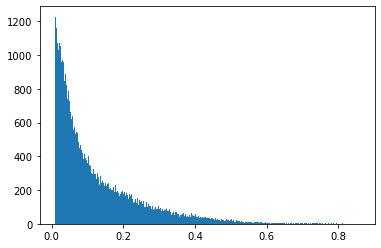

In [21]:
sample = np.random.choice(n, take, p=weight, replace=False)

sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

In [25]:
count

26165

In [ ]:
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample]), 
                                            total=len(sample),
                                           smoothing=0):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
       
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        #if the ligand has any active or inactive assays, we will save them:
        actives = pcv.ligands[str(ligand_idx)]['actives']
        inactives = pcv.ligands[str(ligand_idx)]['inactives']
        if (len(actives) + len(inactives)) > 0:
            #then record the prediction:
            if not pcv.has_prediction(ligand_idx, target_idx):
                pcv.create_prediction(ligand_idx, target_idx, probability)

    except KeyboardInterrupt:
        raise
    except Exception:
        pass
                
    if count>0 and count%2000==0:
        pcv.save_checkpoint()

/home/lewis/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


[243799    199]
[312712    123]
[95376   205]
[296481    185]
[325015      0]
[279705     79]
[186653    197]
[41751   212]
[16970   127]
[108636    257]
[260670     95]
[107813    226]
[57649    88]
[74024    91]
[188147    211]
[182702    167]
[208326    175]
[102209    168]
[183386    119]
[94359   226]
[68705   105]
[339998     74]
[330246    123]
[37491    71]
[151390    154]
[153357    274]
[341698    201]
[194789     18]
[270090    140]
[218133    129]
[315102     25]
[200540    205]
[201876    154]
[131354    144]
[187839    246]
[266456     23]
[43842    80]
[89541   121]
[81040   226]
[63193   131]
[248328    217]
[182263    250]
[60665   122]
[304848    184]
[339249    312]
[98382   214]
[270879    311]
[251398     91]
[42697   311]
[195104    122]
[172455    102]
[326062    112]
[136150     25]
[347572    216]
[175498    119]
[190769      0]
[141116    216]
[96537    80]
[162401    216]
[44087   117]
[32528   168]
[56725     1]
[18374    94]
[290777    154]
[341943     85]


[121501    213]
[218534    239]
[217512    309]
[170163     16]
[116200    214]
[151786    226]
[265000    217]
[9022  154]
[195658    205]
[7400  144]
[47920   309]
[195929    168]
[282993    108]
[323157    174]
[71811   226]
[174337    154]
[265844     98]
[353016    144]
[268747     71]
[35535    53]
[227792    293]
[22267   229]
[171443    144]
[264085    306]
[145319    258]
[319178    220]
[146455    308]
[87274   180]
[125352    229]
[345103    151]
[93526    77]
[16989   168]
[292269    180]
[183373     91]
[109648    140]
[86635   168]
[313924     77]
[262119     88]
[112235    226]
[234550    159]
[182250    213]
[22511   226]
[64879   119]
[357629     94]
[89089   214]
[142972    144]
[20808   180]
[131768    245]
[256452    228]
[297760     71]
[310326    123]
[339574    101]
[321719     95]
[355970     19]
[331337     87]
[176931     82]
[143557    194]
[312106    110]
[186148    175]
[69903   309]
[25044   153]
[55448   215]
[160964    256]
[62100   215]
[345731    105]


[353527     96]
[3467  201]
[33509   167]
[19333   200]
[17196   198]
[177458    172]
[287815    195]
[207783    167]
[188718    143]
[189626    110]
[276059    154]
[316994     77]
[190141     71]
[68004   136]
[242476     71]
[349868     91]
[39311    77]
[311817    180]
[92286    96]
[95123   211]
[102002    205]
[180477    155]
[18355   147]
[313336    101]
[23557   134]
[78203   228]
[304778     55]
[325787    324]
[200517    122]
[317620    172]
[38774   323]
[332570    211]
[290823     29]
[266310    206]
[228152    277]
[151102    201]
[15286   211]
[116263    144]
[338251    216]
[126861    160]
[128955    174]
[75478   228]
[134281    123]
[49611   226]
[352545    228]
[37232   229]
[279202    206]
[62605   154]
[254935    201]
[21329   153]
[272637    108]
[199207     58]
[87832   231]
[69890   144]
[337592    211]
[194246    216]
[129861    291]
[242766    228]
[86870   310]
[96332   146]
[134896    226]
[281317    276]
[143794    167]
[33359   180]
[330983     74]
[13334  

[33602   220]
[175952    229]
[317649    117]
[39752   216]
[19632    60]
[19350    91]
[153775     96]
[136489    216]
[318655     77]
[357214    160]
[65113   226]
[159808    154]
[149228    291]
[247939    216]
[307620     71]
[322295     91]
[174197    185]
[79829   180]
[86529   235]
[104178    226]
[347249     22]
[218113    275]
[168160    136]
[232427    316]
[355139    210]
[329548     82]
[319049    204]
[329547     97]
[260189    154]
[65261   274]
[198366    220]
[71798   122]
[19184   167]
[2233  194]
[41062   136]
[354023    261]
[37270   226]
[161120     43]
[138361    210]
[106390    229]
[47658   226]
[75350   312]
[301686    110]
[154449    226]
[164476    131]
[145603    210]
[85164   312]
[158063    119]
[176570    129]
[195596     77]
[266281     71]
[11414    22]
[247332    169]
[144259    167]
[355787    211]
[175394     71]
[42788   152]
[275350    216]
[356582    342]
[103807     55]
[130730    112]
[211756     22]
[168689    309]
[148968    140]
[8978  228]
[3

[188710    105]
[173943    129]
[265009    121]
[202512    199]
[239045     55]
[77056   228]
[255610    226]
[200904    159]
[39126   229]
[321764     74]
[27679   123]
[61024    68]
[113854     91]
[268660    226]
[37992   216]
[129025    175]
[135401     97]
[3720  140]
[203041    316]
[155948    117]
[86695    91]
[38842   226]
[181164    303]
[175918    205]
[121464    310]
[177707    119]
[347348    306]
[355245     91]
[215237    283]
[345883    124]
[30088   180]
[247716    144]
[161252     48]
[71792   226]
[309409    169]
[30729    74]
[168584    154]
[277488    235]
[222191    239]
[8653  124]
[132037    245]
[80964   277]
[325499    108]
[172836    211]
[311324    136]
[251282    159]
[139008    122]
[273628    117]
[127204    216]
[31819   216]
[64209    13]
[153130    216]
[138731    205]
[164492     91]
[89263   144]
[130122    129]
[204219     52]
[77350    96]
[353759    210]
[108939    228]
[305952    228]
[168671     74]
[1085  282]
[279868    316]
[361 124]
[140725 

[159605    229]
[79426   154]
[74481   119]
[130099    291]
[353493     85]
[353277    154]
[49599   226]
[71605   157]
[48202   206]
[143242     60]
[159143    101]
[246332    228]
[281458    239]
[336198    153]
[214834     71]
[114065    134]
[134901    204]
[16229    71]
[332614    205]
[157362    144]
[94406    74]
[296176    117]
[313174    316]
[9211  167]
[168370    127]
[18970   119]
[43796   154]
[131218    122]
[214870    213]
[344916    308]
[93335   226]
[166494    316]
[116064    168]
[346194     24]
[214442    202]
[38588   216]
[173840     85]
[169769     78]
[44281   211]
[172147    226]
[170378    226]
[250172    136]
[41009    50]
[328281    105]
[58411   226]
[74070   147]
[53376    14]
[160100     96]
[109095    182]
[325292     85]
[43686    71]
[149253     29]
[328130    261]
[187694    226]
[334453     77]
[323863     91]
[208081    291]
[188094    112]
[305348    226]
[151263    229]
[8654  228]
[156868    154]
[347766    144]
[211636    167]
[48821    85]
[207

[200428    228]
[160924    184]
[107101     91]
[41805    53]
[123046    205]
[137344     94]
[242285    211]
[191442    101]
[116365     91]
[149779    210]
[90115    91]
[346649    103]
[319469    214]
[334857    134]
[74323   184]
[5158  283]
[158262     99]
[66575   229]
[327197    123]
[97414   180]
[278241    154]
[271492    184]
[248862    174]
[349340    206]
[61351   258]
[86131    91]
[32163    85]
[169696    228]
[254527    228]
[210640    184]
[255660    226]
[329738    216]
[218468    175]
[163522    202]
[287025    321]
[118102    105]
[184578    226]
[181308    235]
[25599   103]
[337024    307]
[350578    105]
[121248     88]
[73771    71]
[310646     45]
[188712    144]
[312655    283]
[49175   226]
[82594    53]
[157773    168]
[190752    136]
[135208    122]
[258771    167]
[60752    17]
[187609    104]
[212447    197]
[118087    136]
[27140   213]
[67903   153]
[45396   226]
[246078    122]
[86442   101]
[193718    201]
[256724    115]
[37210   213]
[107410    134]


[56767     2]
[163210    105]
[339395     91]
[70066   216]
[122586    275]
[256756    172]
[29154   157]
[132051    326]
[192909    121]
[247035    167]
[81260    91]
[72086   274]
[169689    154]
[342015    140]
[66073   226]
[78444   129]
[81546   105]
[129622     91]
[242295    210]
[183704    124]
[1203  159]
[32734   157]
[209604     77]
[86861   185]
[355878    201]
[69738   216]
[331073    306]
[295225    306]
[321991     52]
[197509     81]
[339758    205]
[334924    184]
[315632     80]
[65470     8]
[52345   226]
[262816     57]
[321493    173]
[158270    201]
[311740     77]
[357429    129]
[21280    91]
[346645     64]
[114504    226]
[65980    74]
[14881   228]
[72354   226]
[26811   226]
[297920    321]
[254326    119]
[124435     96]
[99255   261]
[70592   226]
[68019   111]
[339939    226]
[59944   123]
[105124    174]
[256391    172]
[19586   157]
[355349    210]
[225964    167]
[50911   226]
[29675   226]
[319873    172]
[65852   226]
[160959    105]
[161128    154]


[203383    115]
[180845    216]
[38279   122]
[31146   129]
[138565     94]
[351491    200]
[207060     29]
[344034    105]
[23955    74]
[103487    226]
[182078    167]
[86442    56]
[227347    290]
[190569     96]
[168177    105]
[210732     87]
[181583    155]
[76593    91]
[179349     85]
[198340     52]
[247768    226]
[223926    186]
[112661    129]
[335213     71]
[187411    129]
[14516    96]
[54057     1]
[162258    117]
[145846    129]
[66630   290]
[122357    258]
[144926    228]
[165714     71]
[200555    311]
[270755    119]
[54073   226]
[193148    316]
[17780   220]
[193170    228]
[156647    321]
[212396    311]
[158950    154]
[110198    117]
[162299    274]
[230553    290]
[129950     55]
[48139    53]
[253150    125]
[5261  158]
[256114     77]
[40946   110]
[4788  213]
[162760    121]
[5468  119]
[79122    91]
[316627    200]
[325715    303]
[96366   226]
[27615    96]
[167052     85]
[130126    226]
[134379     82]
[52069   216]
[168710    168]
[33517   226]
[25905

[267855    197]
[86950    97]
[114438    258]
[260116    175]
[216406    319]
[238019    123]
[8440   74]
[357368    122]
[48304   226]
[103504    226]
[208384    173]
[255415    233]
[195511    226]
[18928   119]
[111926    107]
[1655   85]
[318169    129]
[235088    117]
[333115    217]
[115414    236]
[79234   103]
[18304   216]
[197139    153]
[15854    43]
[249637    122]
[74607   172]
[20045   213]
[68948   152]
[96451    38]
[49701   226]
[316146    294]
[11221    91]
[125101     85]
[47386   216]
[193389    316]
[298281     90]
[62853   215]
[24320   226]
[247266     81]
[258404    168]
[68796   216]
[262054    295]
[352907    205]
[110996     24]
[278513     91]
[45531    91]
[47376   117]
[63372   101]
[178469    167]
[255734    118]
[258560    175]
[43444   226]
[295274    300]
[147160    216]
[68684     1]
[246395     77]
[24729   227]
[339336     96]
[340342    228]
[37514   213]
[334223     91]
[8737  144]
[52715   228]
[127696     95]
[26192   229]
[201104    207]
[29347

[314498    172]
[93784     8]
[17975    96]
[237481    231]
[118538    101]
[261147    258]
[191624    105]
[193409    229]
[7159  205]
[207039    319]
[223782     95]
[188715    105]
[316215    226]
[308566     71]
[314913    205]
[14579   117]
[39861   178]
[17986   217]
[41175   216]
[192072    310]
[206099     74]
[204949     74]
[354428    226]
[304981    266]
[257838    110]
[332681     88]
[84363   101]
[40422   140]
[73257   214]
[19140   168]
[221111    167]
[57831   123]
[256835    144]
[353405    228]
[52567   283]
[57773   229]
[169773    321]
[65030   226]
[114439     29]
[189386    284]
[339534    228]
[165019    121]
[120502     88]
[328249    215]
[105042    124]
[15262    78]
[69081   214]
[346775    226]
[33926    31]
[175488    119]
[109389    153]
[270424    291]
[357186     74]
[237681    197]
[187504    119]
[111163    235]
[258152    326]
[356224    211]
[325883    146]
[350412    129]
[111019     74]
[149317    123]
[84436   217]
[307122    151]
[169429    263]


[15570   103]
[65536   153]
[269237     91]
[345041    105]
[58143   129]
[358704    205]
[345339    299]
[147021    124]
[52408   180]
[344015    167]
[82134   152]
[189278     96]
[328896    136]
[71628   226]
[66308   226]
[334344    143]
[50576    56]
[63900   226]
[1671   28]
[104306    168]
[132222     71]
[355503    210]
[62736   226]
[121434    157]
[125139    258]
[309196    226]
[107212    226]
[354201    214]
[201585    299]
[161039    294]
[212500    258]
[333938     55]
[174641    167]
[149042    324]
[74712   311]
[127325    152]
[68479    47]
[341321    130]
[102797    226]
[88056   200]
[188052    136]
[250497    144]
[47590   218]
[41177   216]
[168159    103]
[37139   274]
[42559   228]
[38850   226]
[43079   226]
[211998    167]
[50807   216]
[108366    299]
[57921   152]
[47477   216]
[30478   216]
[160376    211]
[74013   144]
[338150    228]
[167019    258]
[45742   167]
[48164   323]
[136528    117]
[50161   211]
[ 79 160]
[351809    117]
[227207     95]
[72581  

[34093   201]
[169769    121]
[347451    211]
[54872   213]
[41054    91]
[84474    96]
[355757    201]
[250801     39]
[246516     77]
[291473    184]
[105270    226]
[298002    140]
[30747   261]
[25285   229]
[135373    195]
[161692    201]
[87464    91]
[340144    138]
[189683     81]
[24998   270]
[46737   226]
[9246  226]
[350481    219]
[312680    226]
[146767     71]
[115584    226]
[162259    226]
[79977    71]
[24779   226]
[21678    77]
[241257    167]
[311861    246]
[31554    53]
[171387    215]
[343718    119]
[79155   261]
[4456  210]
[327732    140]
[289327    167]
[326660    228]
[142110     81]
[277034    138]
[294404    283]
[310526    216]
[351805    217]
[24782   110]
[289906    216]
[157448     24]
[175229    168]
[169463    154]
[141022    159]
[142648    261]
[103461    324]
[203918    283]
[152945    136]
[139278     85]
[315792    178]
[66703   185]
[164354    144]
[73997    91]
[52851   216]
[59555   205]
[219664    319]
[118420     91]
[55289    94]
[13208  

[222477     94]
[337044    129]
[240980    246]
[240334    258]
[17928   200]
[247539    274]
[25452   283]
[169953    228]
[15375   154]
[8451  154]
[230923    155]
[174868      1]
[22461   226]
[121672    178]
[248647    312]
[117713    101]
[147810    167]
[158006     40]
[81109   153]
[18128    77]
[170934    229]
[114084    249]
[198140    202]
[131845    204]
[76424    56]
[80621   124]
[63538    77]
[187784    140]
[256824    216]
[116368    294]
[194967    213]
[39453   229]
[163718     43]
[75384   106]
[333540    101]
[202386      0]
[253371     43]
[98799   299]
[256347     71]
[34635   140]
[341313    121]
[22898   226]
[182575    226]
[339532     91]
[9803   85]
[50898    53]
[346635    226]
[104019    217]
[38738     1]
[213871    201]
[78444    81]
[57056   226]
[173877    122]
[291912    258]
[277341    226]
[251813    174]
[142348    213]
[8265  190]
[12403   216]
[185870    226]
[183932     77]
[258028    194]
[58803   226]
[ 22 249]
[21042   215]
[46993   229]
[29071

[138734    113]
[64860   155]
[36254    10]
[310318     71]
[151171    168]
[137913     94]
[170927    174]
[149871    283]
[333747     77]
[172015    213]
[322585     91]
[344609     74]
[83875   167]
[106592    217]
[194870     73]
[337690    154]
[190967     94]
[220956    258]
[15654   258]
[267366    223]
[83583   167]
[120915     85]
[311818    210]
[187802    108]
[214020     71]
[331695    129]
[162629    119]
[357823    215]
[313952    144]
[294429    101]
[311605    174]
[ 88 226]
[264138     22]
[335088    119]
[27043   229]
[253705    167]
[136669    172]
[315677    121]
[290264     85]
[205886    125]
[281403     88]
[356280    226]
[336634     49]
[51750   216]
[22909    91]
[169994    123]
[59159   154]
[325597    136]
[99501   340]
[356585    117]
[195143    154]
[146317     91]
[21135   140]
[193898     71]
[332287    228]
[117865    159]
[272496     94]
[17697    24]
[126750     85]
[280551     71]
[117134     22]
[160006     29]
[173566    153]
[100201    226]
[31308

[148453     85]
[312584    105]
[54644   153]
[168760    211]
[78316   153]
[314065    154]
[80551   117]
[19365   119]
[157826    216]
[15421    91]
[11228   205]
[92359   167]
[315340    154]
[338133    154]
[154818    146]
[327313    308]
[8704  177]
[303754    138]
[330938    211]
[136138     40]
[183045    300]
[147961    324]
[246702     85]
[1039  178]
[20797    83]
[352377     49]
[53982   268]
[253619    167]
[32132   214]
[91031   226]
[245824    146]
[269775     22]
[309337    261]
[212045    194]
[308273     22]
[159414    122]
[132764    197]
[46438    94]
[26748   215]
[311607    144]
[173008    213]
[243770    152]
[139035    199]
[285104    291]
[144283     88]
[207693    167]
[78414    97]
[89030   140]
[336085    131]
[320157    144]
[336264    136]
[247296    226]
[154382    105]
[25486   332]
[330167    153]
[241640     52]
[255583    101]
[150440     91]
[55803   105]
[151702    204]
[8126  226]
[278384    200]
[330286     96]
[134177     52]
[93458   164]
[211913 

[72648     8]
[324412     94]
[290692     88]
[357595    210]
[143359    200]
[117345    311]
[106617    277]
[145399     22]
[76980   310]
[195348    214]
[194880    119]
[186444    153]
[355621     73]
[45445   226]
[220533     95]
[197949    140]
[277332    211]
[323909    151]
[218815    167]
[312953    125]
[126953    123]
[352191     24]
[338052    129]
[153734    157]
[108978    101]
[210868    154]
[250954    322]
[200460    184]
[354742     87]
[316405    226]
[18894   110]
[250240      1]
[65895   200]
[197082    134]
[256667    110]
[175489     91]
[93652   226]
[353368    210]
[155901    231]
[11021   200]
[111761    122]
[30971   226]
[348893    216]
[115918    303]
[129307     40]
[241505    159]
[12093    77]
[94029   124]
[83442    53]
[68841   258]
[67537   226]
[134931    226]
[102904    110]
[248901    303]
[43938    85]
[290041    343]
[17108   117]
[191887    168]
[358829    157]
[344066    226]
[266254     55]
[340673    263]
[141462    226]
[200586    140]
[34360

[9304   71]
[180693    226]
[270276    321]
[43996   187]
[323139    167]
[216235    274]
[14007   322]
[75096   101]
[194781     91]
[235208    303]
[21202   213]
[204568    161]
[851 319]
[  5 160]
[276263    167]
[32903   226]
[7430  134]
[274552    311]
[148623    159]
[254191    119]
[275502    291]
[199746    136]
[177199    213]
[65864   226]
[73117   202]
[82487    13]
[323318    229]
[12288   164]
[14334   312]
[345077    213]
[283975    215]
[46633   124]
[171906    136]
[342441    293]
[52440   144]
[197349    223]
[346906    105]
[204222    168]
[337572    226]
[70952   122]
[21315     5]
[174021    119]
[310784     77]
[248595    324]
[6314  220]
[86828    53]
[114418     71]
[265123     77]
[69031   105]
[248744    105]
[77432   157]
[89732    91]
[315965    140]
[214874    159]
[212038     17]
[312705     44]
[151710    121]
[4775   47]
[81057   211]
[355174    227]
[46169   224]
[208088    291]
[69647    70]
[102915    277]
[347771    147]
[333657    129]
[187807     96

[165468     87]
[322110     50]
[86548    91]
[356408    228]
[197780     96]
[64253    94]
[122034     91]
[135759     84]
[326312    205]
[1159   91]
[81647   207]
[351084    136]
[319804    205]
[123907    144]
[1396  117]
[248401    226]
[127622    108]
[240290    258]
[44899   268]
[47160   268]
[917 140]
[179364    124]
[14627    18]
[192871     18]
[194172     81]
[166056     91]
[99468   226]
[129148    112]
[120490    184]
[341274    263]
[166789    319]
[33680   144]
[94370   153]
[39934   316]
[145953    294]
[328852     96]
[191369    294]
[91012   216]
[246998     91]
[12504   207]
[3224  217]
[45558   226]
[186519    103]
[86549   229]
[340640     81]
[62350   226]
[22339   226]
[182099     96]
[336749    167]
[69228   202]
[192176    138]
[182091    322]
[178707     80]
[1193  228]
[27519    64]
[51893   281]
[212415    107]
[11221   200]
[67214   226]
[354150    157]
[135797     94]
[90086   161]
[282618    167]
[120506    184]
[195468     81]
[139853     31]
[77759    

[40853     1]
[200428    205]
[87321   168]
[114434    206]
[275707    258]
[182813     99]
[102398    157]
[247319    228]
[122685     85]
[66322   213]
[138266    210]
[217399    101]
[45283    73]
[199759    136]
[107152    101]
[316892    167]
[358  82]
[46752    77]
[199027     97]
[47826   168]
[17470   108]
[114460    101]
[261236     31]
[252002    226]
[69342    85]
[312057    214]
[288565    105]
[81243   229]
[149693    180]
[61136   155]
[232692     85]
[347154    226]
[328120    103]
[322343    140]
[8942  211]
[42633   180]
[301250    167]
[91286    91]
[99394   167]
[19547    91]
[171821    212]
[180152    119]
[50125   153]
[108474    343]
[330232    311]
[271279    202]
[104282    214]
[353140    210]
[184757     82]
[124069    239]
[289000     22]
[24927   123]
[246695    152]
[114428    140]
[168414    155]
[108528    167]
[68150   282]
[180515    205]
[240343    258]
[89565   140]
[313976    143]
[314328    167]
[55312   211]
[332223    226]
[200550     36]
[214825 

[214349     53]
[159586     73]
[20320    96]
[62526   261]
[45941   205]
[68022   268]
[179492     74]
[181064    143]
[334653     85]
[78066   117]
[97916   112]
[121356     77]
[126695     88]
[118621    119]
[94232   205]
[226158    209]
[204994    129]
[250601    172]
[145958    201]
[102194    138]
[252315    316]
[325218    167]
[41802    82]
[63920   215]
[240515    112]
[130627    140]
[312895     91]
[331629    147]
[136191     94]
[51640    91]
[334809    276]
[132555    167]
[55145   136]
[32977   226]
[310084    322]
[98919   105]
[333406     71]
[29534   154]
[7798   59]
[279145    316]
[156404    130]
[194539     81]
[289626    258]
[292596     87]
[196032    162]
[230612    290]
[294507    213]
[81682   131]
[294 229]
[125140    258]
[140603    215]
[251455     18]
[46685   214]
[43102   160]
[10050   148]
[6816  175]
[9013   74]
[311866    119]
[611  80]
[167418    132]
[326229      8]
[141589    153]
[241041     55]
[270549    105]
[205005    129]
[22580    53]
[12244

[288520    115]
[9548  211]
[61039   213]
[11577    43]
[321524    226]
[199964     85]
[36384   123]
[112692     91]
[59315   217]
[237486    121]
[20866   189]
[57427   172]
[68753   226]
[337655     74]
[320250     45]
[345671    174]
[113939    258]
[339011     74]
[143374     85]
[160873     77]
[56417   226]
[62106   294]
[63081   229]
[91559   153]
[191696     32]
[10628     0]
[356886    309]
[187735     91]
[102209    210]
[181279    136]
[54968   228]
[230575    290]
[148784    182]
[318281    167]
[17268   197]
[353954    119]
[79770   229]
[93605    71]
[237698    258]
[340792    103]
[335794     77]
[323500    105]
[86088    91]
[187582    213]
[346523    101]
[256957    216]
[1124  258]
[167050     91]
[27829    12]
[123963    153]
[352234    226]
[28828   274]
[333472    308]
[254766    130]
[294415    167]
[98787   129]
[36991   167]
[138719    205]
[350759    226]
[59817   229]
[352313     53]
[247841    211]
[82408   216]
[52806   216]
[324267    210]
[241526    206]


[200579    216]
[260845     94]
[189663    201]
[181807     31]
[303830     94]
[152062    129]
[247697    136]
[266530    205]
[299001    291]
[323896     91]
[230266     96]
[273711     71]
[339562     53]
[298932     88]
[193685    226]
[63400    73]
[152241    143]
[93596   229]
[88793    52]
[216383    306]
[204937    129]
[250580    157]
[43574   229]
[321074     77]
[73479   153]
[142932    129]
[52262   123]
[323725     81]
[195302    300]
[298666    319]
[96389    96]
[356828    140]
[353551    299]
[36520   200]
[239286     71]
[156897    167]
[29915   323]
[88343   190]
[296149    129]
[20965   229]
[24753    53]
[169168    207]
[310872     82]
[314689    154]
[51306   323]
[110779    155]
[73503   226]
[171680    167]
[159532    157]
[51882    77]
[192346    226]
[50932   144]
[201419    226]
[86633    91]
[56375   228]
[162796    261]
[136534    121]
[85654   261]
[278347     85]
[48854   168]
[114444    198]
[30345   215]
[185767     53]
[38804   218]
[152125    216]
[310

[23508    73]
[141396    229]
[191462    101]
[22467   136]
[20230   160]
[146001    100]
[40355   214]
[119180    316]
[32605   226]
[39143   216]
[131181    307]
[190480    117]
[76702   201]
[31708    71]
[178071    228]
[157036    316]
[189662     71]
[56854   233]
[294285    229]
[84326   316]
[83958   311]
[201203    182]
[343678    140]
[105701    276]
[296077    327]
[345138    164]
[273627    216]
[320370    210]
[227708    153]
[277701    175]
[129781    180]
[253193     85]
[160397    168]
[331714    228]
[127816     91]
[154626    172]
[146886    226]
[300100    311]
[154403    211]
[14259   226]
[283759    167]
[175599    105]
[171262    229]
[167096    266]
[323863    131]
[202633    134]
[346259    143]
[39311   154]
[184745    216]
[296239     57]
[305962    291]
[118851     36]
[148521    111]
[330073    101]
[213659    205]
[337468    211]
[248706    246]
[170838    226]
[303172     94]
[169963    115]
[192889    226]
[26801   216]
[170564      8]
[16914   184]
[25778

[2463  144]
[44130   213]
[61523   123]
[324070    207]
[187518    201]
[239531    303]
[ 57 200]
[32053   226]
[254105    157]
[355074    211]
[52343   216]
[115354    123]
[356995    201]
[280055     53]
[107892    281]
[7958  228]
[329795    289]
[257134     91]
[294392     13]
[322493    174]
[161718    105]
[204883     85]
[307099    117]
[240136     71]
[96859   140]
[179812    201]
[14932   215]
[64333    77]
[49476    74]
[250775    184]
[112608     17]
[64446   216]
[108315    112]
[163439    167]
[143760    226]
[24066   167]
[73058   144]
[201897    129]
[194614    119]
[145951    294]
[312646    303]
[38308   268]
[147666    129]
[338348    213]
[112549    177]
[106206     77]
[284668    217]
[259616     96]
[254933     88]
[174884     22]
[69314   102]
[54020   229]
[71983   226]
[314832    180]
[174436    207]
[195039    226]
[18801   228]
[346939     85]
[60690   323]
[158469    228]
[315919    160]
[69808   136]
[161142    295]
[295483    146]
[103904    265]
[200192   

[119555    178]
[155623    154]
[312580     81]
[138300    210]
[336883    277]
[117873     71]
[253387    167]
[331222    226]
[257322    339]
[223908    246]
[358705    228]
[151960     71]
[213200    274]
[349511    119]
[198576    216]
[132745    184]
[18803    52]
[196927     96]
[2071  101]
[9103  134]
[279176    231]
[73959    85]
[95126   211]
[11914    90]
[16761   164]
[197734     77]
[175441     91]
[31311    78]
[51887   190]
[28238   154]
[138627     13]
[56112   144]
[341079    112]
[349700     91]
[12463   207]
[168552    115]
[246575    124]
[320731    226]
[265752    258]
[115256     22]
[281482    213]
[253339    236]
[294653    223]
[126146    103]
[353158     77]
[226575    226]
[216839    103]
[24410    77]
[100145     73]
[68901   213]
[93956    77]
[200767    167]
[96387    85]
[98144   117]
[132770    198]
[36229    13]
[332729    122]
[82331   303]
[153389    103]
[181819     22]
[35583   123]
[171293    153]
[195570    249]
[159808     77]
[135721    180]
[127

[17044   303]
[142974    144]
[31654   226]
[134579    143]
[311323    140]
[237668    199]
[208868     88]
[64853   178]
[194512    220]
[4630  122]
[120148    216]
[328322    205]
[93062   119]
[72872    91]
[236009     77]
[329308    226]
[342297     87]
[104386    265]
[129756    211]
[61007   229]
[102278     45]
[357542    311]
[243043    205]
[130314    294]
[120820    187]
[49473    71]
[157464     91]
[309490     55]
[281223    322]
[186255    119]
[337676     91]
[166504    316]
[251646    275]
[179966     85]
[300572     87]
[138261    214]
[3757  121]
[343777    154]
[86802   226]
[193873     81]
[124923     52]
[33343   226]
[97795   210]
[182793    308]
[276950     55]
[158845    105]
[70934    91]
[157364    321]
[17535   157]
[327049    216]
[194473    205]
[260118     55]
[4525   84]
[54770   226]
[318839    168]
[53061   167]
[158521    131]
[251236    274]
[166067     96]
[124508     71]
[337774    167]
[191913    168]
[8452  154]
[16084    91]
[13573   115]
[345927 

[167990     41]
[309581    173]
[111485    143]
[29873   226]
[133198    136]
[103471    291]
[64140   140]
[160511    309]
[62496   226]
[70061   218]
[7465  261]
[57373    53]
[181616    311]
[107052    124]
[510 201]
[92985    68]
[237661    199]
[209548     42]
[102561    197]
[140607    168]
[275208    155]
[178847    167]
[80640   226]
[95054   172]
[153545    105]
[93692    81]
[177602    215]
[119203    101]
[352028    205]
[153581     85]
[89157    85]
[135859    274]
[175271    233]
[79157   226]
[171155    153]
[131903    216]
[108034    117]
[25045   273]
[108534    275]
[287541    121]
[132249     97]
[280748     22]
[140599    211]
[201245    140]
[18293   174]
[138975      1]
[315840    233]
[159932    340]
[346165     77]
[327735    154]
[83136    77]
[255729    167]
[349141     77]
[102587    184]
[291746    122]
[130083    129]
[45356   205]
[321044    153]
[227378     95]
[193625     18]
[202778    172]
[3019  151]
[287554    261]
[9117  200]
[141797    205]
[123002 

[182105    200]
[319880     95]
[48800    53]
[200290    206]
[15641    71]
[261544    173]
[350423    231]
[107131    136]
[333270    140]
[265047    283]
[286208     22]
[200204    311]
[76532   213]
[62093   178]
[270343    311]
[98962   316]
[352999    101]
[99945    84]
[164868    274]
[82573    68]
[275711    119]
[99947    84]
[351660    277]
[136105    205]
[138979    117]
[140478    101]
[177229      8]
[105456    182]
[73998   103]
[103817    211]
[248468    140]
[202504    210]
[11621   105]
[143971     87]
[104244    144]
[45752    77]
[195950    122]
[43944   261]
[172306    226]
[61242   277]
[37713   216]
[42923   229]
[103488     95]
[55028   105]
[332570    201]
[118435    143]
[129999    313]
[165462    148]
[26678   226]
[252870    167]
[29861    59]
[95009    94]
[329119    228]
[208178    327]
[131900    184]
[35140   215]
[293143    258]
[294870     62]
[48849   226]
[339548    228]
[318135    294]
[82615   159]
[315183    112]
[175381    129]
[21952    85]
[13184

[161266    103]
[246666     43]
[346831    261]
[333663     61]
[15771   322]
[322826    167]
[69704   244]
[249042     22]
[327573    153]
[42440   167]
[256287    172]
[121967    310]
[185342    310]
[275445    228]
[36118    47]
[325024     91]
[60895   153]
[91824   167]
[173251    123]
[311499    233]
[356435    226]
[37793    77]
[43768   136]
[104954     91]
[109456     51]
[191978     91]
[290448     77]
[2417   53]
[354714    124]
[26659    36]
[313387    295]
[91581    74]
[310894    144]
[284925    226]
[154228     71]
[190599    274]
[356375    226]
[28249   229]
[72493   226]
[183618    167]
[5744   96]
[198594     43]
[275975    226]
[139865    167]
[129550    161]
[24363   215]
[264017    173]
[247261     89]
[328114    195]
[272253    214]
[33048   229]
[341921    140]
[49755    53]
[115620    125]
[160255    226]
[259922    159]
[222695    227]
[22053   157]
[62107   123]
[106928    194]
[247207    162]
[237493    121]
[112738    311]
[345370     91]
[350210    147]
[5

[65466   281]
[161069    108]
[136559    121]
[249661    215]
[182083    167]
[113932    258]
[320789    261]
[312728    226]
[98925   226]
[39613   226]
[332745     77]
[192533    123]
[19835   167]
[152472    143]
[312531    144]
[316450    167]
[90240   167]
[250731    140]
[10374   226]
[333041    116]
[267878    119]
[195378    129]
[36039   105]
[121293    125]
[30069   226]
[342552    138]
[238305    152]
[30966   216]
[137642    140]
[183633    101]
[74783   102]
[65918    56]
[24426   184]
[230569    290]
[158426    154]
[341880     82]
[115637    217]
[116671    274]
[261416    167]
[45763    53]
[346321    134]
[325757    256]
[314925    210]
[37324   218]
[341105    205]
[13655   205]
[97872   144]
[243260    140]
[161304     71]
[24114   226]
[105599    270]
[210031    299]
[132264    231]
[247183     49]
[99041   276]
[58657    96]
[141996    167]
[266398     90]
[350747    117]
[1131   96]
[198529    274]
[170375    154]
[253197    226]
[45144   215]
[312279     24]
[133

[168055    229]
[2712  160]
[249879    215]
[254590    167]
[73182   108]
[150342    168]
[94475   228]
[94370   226]
[251329    167]
[44184   216]
[266985    173]
[314843    316]
[84131   277]
[330843    175]
[179192    119]
[156072    229]
[291927    197]
[241064    178]
[181558    204]
[337501    138]
[130263    184]
[9677  216]
[9817   91]
[200480    140]
[347578    322]
[326026    177]
[15874    49]
[12135   207]
[242504    138]
[29621   323]
[195430    129]
[326545    151]
[39677    24]
[40168     8]
[200827    205]
[79008   213]
[288839     85]
[189746    119]
[28289   226]
[63958   215]
[175538     22]
[49893    53]
[129915     91]
[169334    233]
[354553    172]
[344611     71]
[312453    123]
[13275   226]
[188035    101]
[62088   268]
[180083    276]
[14787   226]
[163400    101]
[254229    303]
[111014    101]
[38719   228]
[94805    94]
[6591  333]
[121504    226]
[335923    213]
[169471    308]
[147382     91]
[348529     22]
[313304     91]
[354376    174]
[286117     55

[173854     91]
[307334    167]
[23544   216]
[85410   101]
[170366    226]
[343849    108]
[154817    303]
[199846    228]
[49693   153]
[113180    226]
[103520    167]
[89854   209]
[15520   119]
[197094    261]
[193533    168]
[172017    123]
[287191    159]
[241932    157]
[45270   154]
[146969    217]
[48038    77]
[108617    231]
[136377    103]
[132050    167]
[243638     96]
[60029   178]
[80528   132]
[47030    16]
[194288    213]
[89240    94]
[172424    129]
[164926    111]
[132038     45]
[258003     52]
[239710    197]
[341293    103]
[311359    205]
[67804   154]
[39749    85]
[51790   201]
[264243    277]
[280698    167]
[128326    211]
[460  77]
[349688    164]
[139129    155]
[179473    321]
[202117    226]
[48604   153]
[20459    85]
[44143   224]
[345490     91]
[55277   105]
[39401   228]
[311917    154]
[30534   136]
[105818    105]
[332240    213]
[110872    152]
[109396    133]
[227197     95]
[259719     52]
[207176    175]
[140502    226]
[82339   323]
[352246 

# More!

In [ ]:
sample = np.random.choice(n, take, p=weight, replace=False)

sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

In [ ]:
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample]), 
                                            total=len(sample),
                                           smoothing=0):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
       
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        #if the ligand has any active or inactive assays, we will save them:
        actives = pcv.ligands[str(ligand_idx)]['actives']
        inactives = pcv.ligands[str(ligand_idx)]['inactives']
        if (len(actives) + len(inactives)) > 0:
            #then record the prediction:
            if not pcv.has_prediction(ligand_idx, target_idx):
                pcv.create_prediction(ligand_idx, target_idx, probability)

    except KeyboardInterrupt:
        raise
    except Exception:
        pass
                
    if count>0 and count%1000==0:
        pcv.save_checkpoint()